# AIS WBM
---
### Script for the WBM side of GBM
+ The saved, optimised trained model will be used to predict SOG 
+ Predicted SOG then converted to STW
+ STW then will be used to predict FOC
+ Power estimation using [HoltropMennen84](https://repository.tudelft.nl/islandora/object/uuid%3Aca12a502-fc85-45e4-a078-db7284127e3c)
---
### General Remarks 
+ Please remember to save the model used in BBM part
+ This file should be saved on local directory
+ Running time is significantly shorter 
---
### Package initialisation
+ Loading of standard packages

In [46]:
import pandas as pd
import numpy as np
import math
import joblib
import matplotlib.pyplot as plt
# Gridpsec used for plotting
import matplotlib.gridspec as gridspec

### Loading of models 

In [47]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif"
# })

# model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')

# model_etr = joblib.load('savemodel_etr.sav')
# model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

# model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
# model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')

# model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

In [48]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif"
# })

# model_rfr_ftr = joblib.load('savemodel_rfr_ftr_all.sav')
# model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov_all.sav')

# model_etr = joblib.load('savemodel_etr_all.sav')
# model_etr_hpov = joblib.load('savemodel_etr_hpov_all.sav')

# model_dtr_ftr = joblib.load('savemodel_dtr_ftr_all.sav')
# model_dtr_hpov = joblib.load('savemodel_dtr_hpov_all.sav')

# model_mlr_ftr = joblib.load('savemodel_mlr_ftr_all.sav')

In [49]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr_newds.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov_newds.sav')

model_etr = joblib.load('savemodel_etr_newds.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov_newds.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr_newds.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov_newds.sav')

model_mlr_ftr = joblib.load('savemodel_mlr_ftr_newds.sav')

### Loading dataset

In [50]:
# Parameter to plot in latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

# Load the data to the script

# dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
# dfmain = dfmain[dfmain['LAT'] > 55.04 ]
# dfmain = pd.read_csv("07_AIS_Weather_Hammershus_Adjustment.csv",parse_dates=["Time"])



# dfpre = pd.read_csv("01_AIS_Weather_Hammershus_Rename.csv",parse_dates=["Time"])
# dfpre = dfpre[dfpre['LAT'] > 55.04 ]

dfmain = pd.read_csv("Hammershus_Clean9Copy.csv",parse_dates=["Time"])


dfpre = pd.read_csv("AIS_Weather_Hammershus_RenameCopy.csv",parse_dates=["Time"])

In [51]:
# dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
# dfmain = dfmain[dfmain['LAT'] > 55.04 ]

# dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
# dfpre = dfpre[dfpre['LAT'] > 55.04 ]

### Same as main script, preprocessing of current and wind 

In [52]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [53]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,Width,Length
count,8757.000000,8757.000000,2327.000000,2327.000000,8757.0,8757.0
mean,1.925214,0.369892,0.016358,0.004592,25.0,158.0
std,5.424935,4.401074,0.098862,0.081811,0.0,0.0
min,-15.766171,-12.824582,-0.491010,-0.362739,25.0,158.0
25%,-1.970517,-2.572080,-0.036956,-0.042339,25.0,158.0
50%,2.233890,0.358651,0.019653,0.004664,25.0,158.0
75%,5.887030,3.343947,0.072544,0.052015,25.0,158.0
max,16.338177,14.519458,0.397917,0.364966,25.0,158.0


Imputing value in the preprocessed dataset

In [54]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [55]:
x_pre = imputer.transform(dfpre)

In [56]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [57]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [58]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,Width,Length,Current Speed,Wind Speed
count,8757.000000,8757.000000,8757.000000,8757.000000,8757.0,8757.0,8757.000000,8757.000000
mean,1.925214,0.369892,0.015703,0.005563,25.0,158.0,0.089005,6.561079
std,5.424935,4.401074,0.081205,0.064240,0.0,0.0,0.055459,3.096838
min,-15.766171,-12.824582,-0.491010,-0.362739,25.0,158.0,0.000735,0.193221
25%,-1.970517,-2.572080,-0.022685,-0.029143,25.0,158.0,0.046524,4.159611
50%,2.233890,0.358651,0.018328,0.007771,25.0,158.0,0.076852,6.302331
75%,5.887030,3.343947,0.061227,0.038838,25.0,158.0,0.119249,8.639280
max,16.338177,14.519458,0.397917,0.364966,25.0,158.0,0.497666,18.574455


In [59]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))


In [60]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [61]:
# Descriptive statistics of the dataset for true north weather direction

dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','Width','Length'],axis=1)

In [62]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Draught,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,8.0,2021-01-01 08:00:00,14.572800,55.118090,276.900391,1.261916,1.661038,4.291309,3.667458,3.757862,...,5.0,94.679234,176.354515,78.908928,87.592689,86.949150,0.122270,7.112664,251.408180,68.408246
1,9.0,2021-01-01 09:00:00,14.150895,55.261799,276.705566,1.262235,1.501637,4.187211,3.145607,3.803910,...,5.0,68.884377,149.869518,134.548587,115.015200,120.971331,0.082234,6.653538,254.458891,43.254661
2,10.0,2021-01-01 10:00:00,13.827534,55.399500,276.309815,1.256282,1.235528,4.012717,2.120399,3.819602,...,5.0,150.501089,119.605416,38.784951,27.394112,31.986718,0.080286,6.488697,259.749663,27.719662
3,11.0,2021-01-01 11:00:00,13.844634,55.393668,276.399902,1.256545,1.204397,4.020009,2.090308,3.820546,...,5.0,174.255983,92.029925,11.597842,6.938260,4.612765,0.099846,6.104632,266.724504,57.259552
4,12.0,2021-01-01 12:00:00,14.169006,55.249699,277.134033,1.262830,1.275907,4.095175,3.029945,3.815268,...,5.0,102.756416,35.875258,47.548239,68.041296,53.841284,0.080016,6.181707,174.494060,2.978495


### SOG threshold
+ The threshold for the ships manouvering speed will be 5 knots ([Abebe20](https://doi.org/10.3390/app10072325),[Yan21](https://doi.org/10.1016/j.tre.2020.101930))
+ Alternatively, outlier rejection using &mu; &plusmn; 3&sigma; ([Gkerekos19](https://doi.org/10.1016/j.oceaneng.2019.106282)), this should increase the threshold to about 8 knots

In [63]:
# SOG threshold according to Abebe20 and Yan21

# df = df[df['SOG'] > 0 ]


df = df[df['SOG'] > 5 ]

# # Improve model performance ? , reduce skew of the dataset by removing outliers mu pm 3sigma 

# df = df[df['SOG'] > 8 ]

### Data split into testing dataset
+ The `random_state` is 42, however to gain different datasets, change the `random_state` to other numbers (arbitrary), but make sure the same ``random_state`` is applied to the main BBM script that is used for the split
+ The testing dataset is further split into
    + Summer dataset ``dfsummer``
    + Winter dataset ``dfwinter``
    + Year dataset ``dfyear``, which represents the ``test_set``

In [64]:
# Exclude data for the month of June to check the model's forecasting performance 

from sklearn.model_selection import train_test_split

#When performing the split, make sure that the random state is the same as the training script

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

print("Summer Dataset Breakdown")
dfMay = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-05']
print(f"length of May dataset {len(dfMay)}")
dfJune = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-06']
print(f"length of June dataset {len(dfJune)}")
dfJuly = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-07']
print(f"length of July dataset {len(dfJuly)}")
dfAug = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-08']
print(f"length of August dataset {len(dfAug)}")
dfSep = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-09']
print(f"length of Sept dataset {len(dfSep)}")
dfOct = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-10']
print(f"length of Oct dataset {len(dfOct)}")

print("Winter Dataset Breakdown")
dfNov = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-11']
print(f"length of Nov dataset {len(dfNov)}")
dfDec = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-12']
print(f"length of Dec dataset {len(dfDec)}")
dfJan = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-01']
print(f"length of Jan dataset {len(dfJan)}")
dfFeb = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-02']
print(f"length of Feb dataset {len(dfFeb)}")
dfMar = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-03']
print(f"length of March dataset {len(dfMar)}")
dfApr = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-04']
print(f"length of April dataset {len(dfApr)}")


frames_summer = [dfMay,dfJune,dfJuly,dfAug,dfSep,dfOct]
frames_winter = [dfNov,dfDec,dfJan,dfFeb,dfMar,dfApr]

dfsummer = pd.concat(frames_summer)
dfwinter = pd.concat(frames_winter)
dfyear = test_set

Summer Dataset Breakdown
length of May dataset 35
length of June dataset 104
length of July dataset 139
length of August dataset 137
length of Sept dataset 134
length of Oct dataset 108
Winter Dataset Breakdown
length of Nov dataset 103
length of Dec dataset 98
length of Jan dataset 93
length of Feb dataset 80
length of March dataset 82
length of April dataset 78


Descriptive statistics of different datasets

In [65]:
print(dfsummer.describe())

        Unnamed: 0         LON         LAT  Temperature above oceans  \
count   657.000000  657.000000  657.000000                657.000000   
mean   4822.132420   13.627024   55.118423                286.004301   
std    1951.878884    0.753182    0.239645                  6.149459   
min      96.000000   12.212892   54.472520                269.218018   
25%    3758.000000   12.932376   55.028211                282.958252   
50%    5024.000000   13.808044   55.179564                287.809570   
75%    6308.000000   14.217905   55.257404                290.848877   
max    8247.000000   14.672921   55.458223                297.026611   

       Air density above oceans  Max wave height  Swell period  \
count                646.000000       606.000000    606.000000   
mean                   1.228756         1.567284      4.153648   
std                    0.030675         1.252310      1.078349   
min                    1.170450         0.172342      1.967748   
25%                  

In [66]:
print(dfwinter.describe())

        Unnamed: 0         LON         LAT  Temperature above oceans  \
count   534.000000  534.000000  534.000000                534.000000   
mean   3997.082397   13.418043   55.228225                279.182176   
std    3006.092200    0.798522    0.142580                  5.270506   
min      17.000000   12.213754   54.624047                265.853058   
25%    1314.750000   12.617443   55.139450                275.763489   
50%    2823.500000   13.342714   55.231549                277.989624   
75%    7603.750000   14.100572   55.322679                281.190063   
max    8737.000000   14.627214   55.457504                293.066406   

       Air density above oceans  Max wave height  Swell period  \
count                515.000000       467.000000    467.000000   
mean                   1.259586         1.484179      4.236790   
std                    0.029257         0.948685      0.914978   
min                    1.191707         0.166849      2.118870   
25%                  

In [67]:
print(dfyear.describe())

        Unnamed: 0          LON          LAT  Temperature above oceans  \
count  1191.000000  1191.000000  1191.000000               1191.000000   
mean   4452.210747    13.533325    55.167654                282.945515   
std    2513.203928     0.780467     0.209162                  6.693964   
min      17.000000    12.212892    54.472520                265.853058   
25%    2304.500000    12.882237    55.103432                277.026001   
50%    4692.000000    13.611494    55.209254                282.977295   
75%    6544.000000    14.193033    55.271813                289.193970   
max    8737.000000    14.672921    55.458223                297.026611   

       Air density above oceans  Max wave height  Swell period  \
count               1161.000000      1073.000000   1073.000000   
mean                   1.242431         1.531114      4.189834   
std                    0.033724         1.130494      1.010886   
min                    1.170450         0.166849      1.967748   
25%

### Data Preprocessing
+ Similar to BBM
+ Ensure that the dataset have identical data structure for the trained model 

In [68]:
# # For Summer
# dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Width','Length'],axis=1)
# # For Winter
# dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Width','Length'],axis=1)
# # For the whole year of 2021
# dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Width','Length'],axis=1)


In [69]:
# For Summer
dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For Winter
dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For the whole year of 2021
dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)


In [70]:
#For Summer
dfsummer= dfsummer.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For Winter
dfwinter= dfwinter.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For the whole year
dfyear= dfyear.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [71]:
# #For Summer
# dfsummer= dfsummer.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir',
#                             'Air density above oceans' : 'rho_air_ao',
#                             'Surface pressure' : 'p_seasurf',
#                            }, axis=1) 
# #For Winter
# dfwinter= dfwinter.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir','Air density above oceans' : 'rho_air_ao',
#                             'Surface pressure' : 'p_seasurf',
#                            }, axis=1) 
# #For the whole year
# dfyear= dfyear.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir','Air density above oceans' : 'rho_air_ao',
#                             'Surface pressure' : 'p_seasurf',
#                            }, axis=1) 

In [72]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

# For summer 

df_summer = dfsummer[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]
# For Winter

df_winter = dfwinter[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]
# For the whole year

df_year = dfyear[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]

In [73]:
# # Rearrange column to match model 
# # Also dropping the features as described in the main script

# # For summer 

# df_summer = dfsummer[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]
# # For Winter

# df_winter = dfwinter[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]
# # For the whole year

# df_year = dfyear[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]

Imputing to complete the data

In [74]:
import numpy as np
from sklearn.impute import KNNImputer

imputer_s = KNNImputer(n_neighbors=50)
imputer_s.fit(df_summer)

# Transform imputed summer dataset

xsummer = imputer_s.transform(df_summer)

# Column heading set same

df_summer_tr = pd.DataFrame(xsummer, columns=df_summer.columns, index=df_summer.index)

In [75]:
# Impute for winter data 

imputer_w = KNNImputer(n_neighbors=50)
imputer_w.fit(df_winter)

# Transform imputed winter dataset

xwinter = imputer_w.transform(df_winter)

#Column heading set same 

df_winter_tr = pd.DataFrame(xwinter, columns=df_winter.columns, index=df_winter.index)


In [76]:
# Impute for yearly data 

imputer_yr = KNNImputer(n_neighbors=50)
imputer_yr.fit(df_year)

# Transform imputed year dataset 

xyear = imputer_yr.transform(df_year)

#Column heading set same

df_year_tr = pd.DataFrame(xyear, columns=df_year.columns, index=df_year.index)

In [77]:
df_year_tr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,sog,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,282.945515,3.745513,283.817198,0.808538,5.187500,16.808318,185.201229,175.649072,6.370372,0.085467,85.197483,84.424576,94.407976
std,6.693964,0.852211,5.918176,0.551773,0.209903,3.236891,86.903295,89.601309,3.046064,0.054757,56.311555,72.214559,55.255339
min,265.853058,1.967748,273.048584,0.106645,4.700000,5.051765,39.652335,36.754864,0.291621,0.002871,0.029187,0.211782,0.026438
25%,277.026001,3.137187,278.277527,0.397821,5.000000,16.226408,101.278890,99.296271,4.033796,0.042554,33.219213,12.681128,42.673743
50%,282.977295,3.693673,283.452393,0.693676,5.200000,17.944895,165.700352,122.921136,6.136388,0.072329,82.404607,44.663239,97.880895
75%,289.193970,4.180873,289.408936,1.010680,5.383011,18.796294,278.749187,275.572485,8.336454,0.114552,138.279377,167.111686,143.123608
max,297.026611,6.929401,294.732666,3.496446,5.700000,21.147826,311.866157,304.903786,15.897204,0.367573,179.155072,179.882682,179.802032


In [78]:
# Summer dataset
x_date_s = df_summer_tr.drop(['sog'],axis=1)
y_date_s = df_summer_tr.sog
# winter dataset
x_date_w = df_winter_tr.drop(['sog'],axis=1)
y_date_w = df_winter_tr.sog
# Year dataset
x_date_yr = df_year_tr.drop(['sog'],axis=1)
y_date_yr = df_year_tr.sog

In [79]:
print(f"Amount of the test dataset is {len(x_date_yr)}")
print(f"Amount of the summer dataset is {len(x_date_s)}")
print(f"Amount of the winter dataset is {len(x_date_w)}")

Amount of the test dataset is 1191
Amount of the summer dataset is 657
Amount of the winter dataset is 534


Histogram plots of the yearly dataset

In [80]:
# # plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
# axes = df_year_tr.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(11,2))
# for ax in axes.flatten():
#     ax.grid(True, linestyle='--', alpha=0.5)
# plt.show()

In [81]:
x_date_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,282.945515,3.745513,283.817198,0.808538,5.187500,185.201229,175.649072,6.370372,0.085467,85.197483,84.424576,94.407976
std,6.693964,0.852211,5.918176,0.551773,0.209903,86.903295,89.601309,3.046064,0.054757,56.311555,72.214559,55.255339
min,265.853058,1.967748,273.048584,0.106645,4.700000,39.652335,36.754864,0.291621,0.002871,0.029187,0.211782,0.026438
25%,277.026001,3.137187,278.277527,0.397821,5.000000,101.278890,99.296271,4.033796,0.042554,33.219213,12.681128,42.673743
50%,282.977295,3.693673,283.452393,0.693676,5.200000,165.700352,122.921136,6.136388,0.072329,82.404607,44.663239,97.880895
75%,289.193970,4.180873,289.408936,1.010680,5.383011,278.749187,275.572485,8.336454,0.114552,138.279377,167.111686,143.123608
max,297.026611,6.929401,294.732666,3.496446,5.700000,311.866157,304.903786,15.897204,0.367573,179.155072,179.882682,179.802032


In [82]:
# Ignore this part for latex export

# stats_DSyear = x_date_yr.describe().transpose()
# print(stats_DSyear.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [83]:
y_date_yr.describe()

count    1191.000000
mean       16.808318
std         3.236891
min         5.051765
25%        16.226408
50%        17.944895
75%        18.796294
max        21.147826
Name: sog, dtype: float64

In [84]:
x_date_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,286.004301,3.726736,286.686932,0.821881,5.213033,180.379793,171.226505,6.219143,0.083415,87.195644,85.428197,92.937584
std,6.149459,0.934051,5.402507,0.618899,0.213613,88.658541,90.162220,2.985537,0.054460,56.375274,69.784060,56.881636
min,269.218018,1.967748,274.747070,0.114266,4.700000,41.012784,38.133595,0.291621,0.004443,0.172495,0.211782,0.026438
25%,282.958252,3.041207,283.398682,0.366759,5.000000,99.002926,97.273666,3.975014,0.041495,36.042219,14.185714,39.490445
50%,287.809570,3.639042,287.945068,0.673662,5.200000,178.861429,123.147416,5.943068,0.068563,86.312881,48.651546,94.608401
75%,290.848877,4.181604,291.150757,1.039653,5.400000,275.883815,273.227599,8.155920,0.113071,139.768694,164.741167,143.617027
max,297.026611,6.929401,294.732666,3.496446,5.700000,311.866157,304.299694,15.897204,0.337454,179.155072,179.882682,179.600031


In [85]:
# # Ignore this part for latex export

# stats_DSsummer = x_date_s.describe().transpose()
# print(stats_DSsummer.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [86]:
y_date_s.describe()

count    657.000000
mean      17.035473
std        3.210503
min        5.121978
25%       16.328233
50%       18.163665
75%       18.987403
max       21.147826
Name: sog, dtype: float64

In [87]:
x_date_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,279.182176,3.754504,280.245181,0.783224,5.156086,191.133220,181.090320,6.556435,0.087990,82.739071,83.189784,96.253799
std,5.270506,0.736301,4.452504,0.454025,0.201036,84.398913,88.688134,3.111650,0.055067,56.188314,75.144726,52.909591
min,265.853058,2.118870,273.048584,0.106645,4.700000,39.652335,36.754864,0.427826,0.002871,0.029187,1.470000,0.055169
25%,275.763489,3.264905,277.402771,0.446341,5.000000,104.174503,101.096372,4.141282,0.044775,31.399868,12.013374,47.409100
50%,277.989624,3.728289,278.774841,0.731388,5.200000,161.132821,122.865257,6.366622,0.075156,81.457629,33.589579,100.127737
75%,281.190063,4.179608,282.265167,0.968981,5.300000,280.022044,277.939682,8.451004,0.117231,134.869469,168.521519,141.588215
max,293.066406,6.411206,292.665283,3.196778,5.700000,307.531280,304.903786,14.946484,0.367573,179.148714,179.814996,179.802032


In [88]:
# # Ignore this part for latex export

# stats_DSwinter = x_date_w.describe().transpose()
# print(stats_DSwinter.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [89]:
y_date_w.describe()

count    534.000000
mean      16.528842
std        3.250333
min        5.051765
25%       15.960062
50%       17.736217
75%       18.563067
max       20.506417
Name: sog, dtype: float64

### Evaluating model performance on the testing datasets
+ Same metrics used for cross validation, but now MAPE is added

In [90]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MAE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

ETR

In [91]:
# Year dataset
evaluate_SOG(model_etr_hpov,x_date_yr,y_date_yr)

Model Performance of ExtraTreesRegressor(max_depth=30, max_features=16, min_samples_split=8,
                    n_estimators=300, random_state=42)
R^2 SOG = 0.9045
Explained Variance SOG = 0.9046
MAE SOG = 0.6664 Knots
RMSE SOG = 0.9998 Knots
MAD SOG = 0.4662 Knots
MAPE SOG = 4.4579 %


In [92]:
evaluate_SOG(model_etr_hpov,x_date_w,y_date_w)

Model Performance of ExtraTreesRegressor(max_depth=30, max_features=16, min_samples_split=8,
                    n_estimators=300, random_state=42)
R^2 SOG = 0.9196
Explained Variance SOG = 0.9197
MAE SOG = 0.6384 Knots
RMSE SOG = 0.9209 Knots
MAD SOG = 0.4616 Knots
MAPE SOG = 4.2850 %


In [93]:
evaluate_SOG(model_etr_hpov,x_date_s,y_date_s)

Model Performance of ExtraTreesRegressor(max_depth=30, max_features=16, min_samples_split=8,
                    n_estimators=300, random_state=42)
R^2 SOG = 0.8918
Explained Variance SOG = 0.8924
MAE SOG = 0.6801 Knots
RMSE SOG = 1.0553 Knots
MAD SOG = 0.4558 Knots
MAPE SOG = 4.4946 %


RFR

In [94]:
evaluate_SOG(model_rfr_hpov,x_date_yr,y_date_yr)

Model Performance of RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=800, random_state=42)
R^2 SOG = 0.8924
Explained Variance SOG = 0.8925
MAE SOG = 0.7046 Knots
RMSE SOG = 1.0614 Knots
MAD SOG = 0.4964 Knots
MAPE SOG = 4.6932 %


In [95]:
evaluate_SOG(model_rfr_hpov,x_date_w,y_date_w)

Model Performance of RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=800, random_state=42)
R^2 SOG = 0.9157
Explained Variance SOG = 0.9158
MAE SOG = 0.6572 Knots
RMSE SOG = 0.9430 Knots
MAD SOG = 0.4774 Knots
MAPE SOG = 4.3830 %


In [96]:
evaluate_SOG(model_rfr_hpov,x_date_s,y_date_s)

Model Performance of RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=800, random_state=42)
R^2 SOG = 0.8722
Explained Variance SOG = 0.8732
MAE SOG = 0.7362 Knots
RMSE SOG = 1.1470 Knots
MAD SOG = 0.5061 Knots
MAPE SOG = 4.8689 %


DTR


In [97]:
evaluate_SOG(model_dtr_hpov,x_date_yr,y_date_yr)

Model Performance of DecisionTreeRegressor(max_depth=6, max_features=11, min_samples_leaf=9,
                      min_samples_split=8)
R^2 SOG = 0.8450
Explained Variance SOG = 0.8455
MAE SOG = 0.8080 Knots
RMSE SOG = 1.2737 Knots
MAD SOG = 0.5564 Knots
MAPE SOG = 5.4196 %


In [98]:
evaluate_SOG(model_dtr_hpov,x_date_w,y_date_w)

Model Performance of DecisionTreeRegressor(max_depth=6, max_features=11, min_samples_leaf=9,
                      min_samples_split=8)
R^2 SOG = 0.8912
Explained Variance SOG = 0.8914
MAE SOG = 0.7267 Knots
RMSE SOG = 1.0713 Knots
MAD SOG = 0.5188 Knots
MAPE SOG = 4.9333 %


In [99]:
evaluate_SOG(model_dtr_hpov,x_date_s,y_date_s)

Model Performance of DecisionTreeRegressor(max_depth=6, max_features=11, min_samples_leaf=9,
                      min_samples_split=8)
R^2 SOG = 0.8068
Explained Variance SOG = 0.8093
MAE SOG = 0.8690 Knots
RMSE SOG = 1.4100 Knots
MAD SOG = 0.5741 Knots
MAPE SOG = 5.7685 %


MLR

In [100]:
evaluate_SOG(model_mlr_ftr,x_date_yr,y_date_yr)

Model Performance of LinearRegression()
R^2 SOG = 0.8127
Explained Variance SOG = 0.8164
MAE SOG = 1.0297 Knots
RMSE SOG = 1.4002 Knots
MAD SOG = 0.8358 Knots
MAPE SOG = 6.8081 %


In [101]:
evaluate_SOG(model_mlr_ftr,x_date_s,y_date_s)

Model Performance of LinearRegression()
R^2 SOG = 0.7917
Explained Variance SOG = 0.7981
MAE SOG = 1.0709 Knots
RMSE SOG = 1.4642 Knots
MAD SOG = 0.8621 Knots
MAPE SOG = 7.0398 %


In [102]:
evaluate_SOG(model_mlr_ftr,x_date_w,y_date_w)

Model Performance of LinearRegression()
R^2 SOG = 0.8336
Explained Variance SOG = 0.8349
MAE SOG = 0.9756 Knots
RMSE SOG = 1.3247 Knots
MAD SOG = 0.8174 Knots
MAPE SOG = 6.5107 %


### Plot of predicted vs actual SOG values

In [103]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.3f}x {b:+.3f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend(fontsize=14)



0.8450429586684756
y = 0.9 * x + 2.1
0.892385754397561
y = 0.9 * x + 1.8


0.9045206432177411
y = 0.9 * x + 1.6


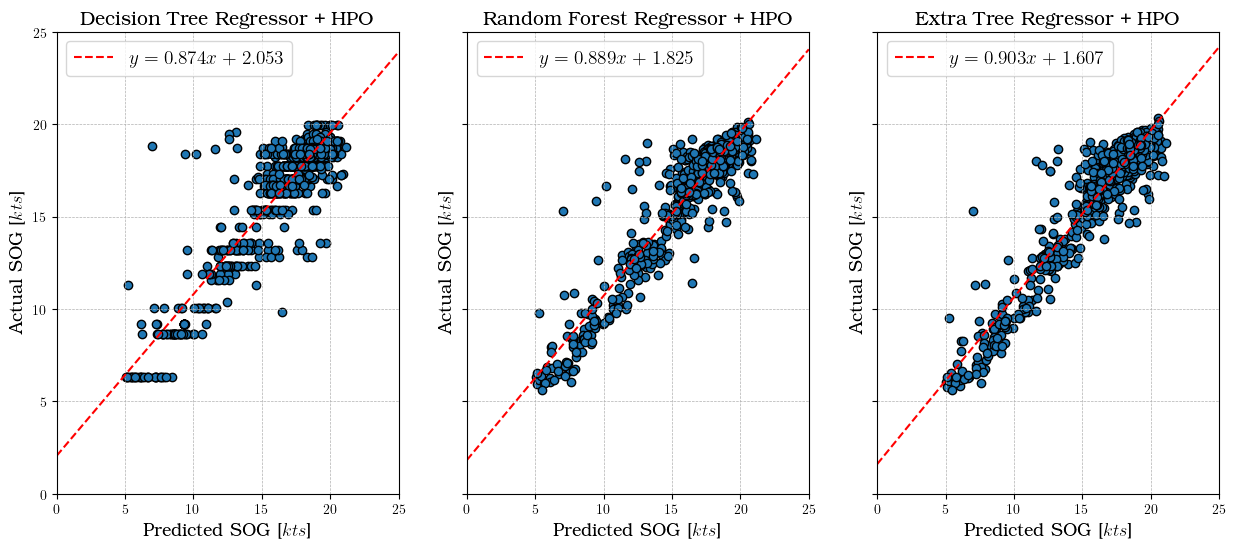

In [104]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[2])
pred_plot(model_etr_hpov,'Extra Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.show()

0.7890311888503582
y = 0.9 * x + 1.0
0.8450429586684756
y = 0.9 * x + 2.1


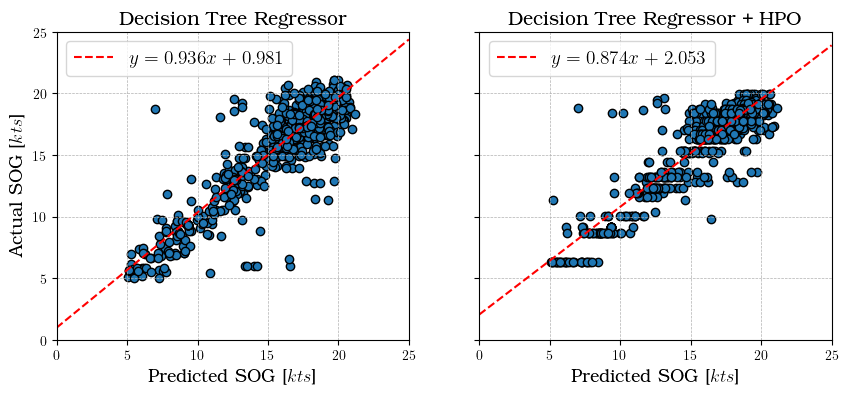

In [105]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.8870906819967638
y = 0.9 * x + 1.6
0.892385754397561
y = 0.9 * x + 1.8


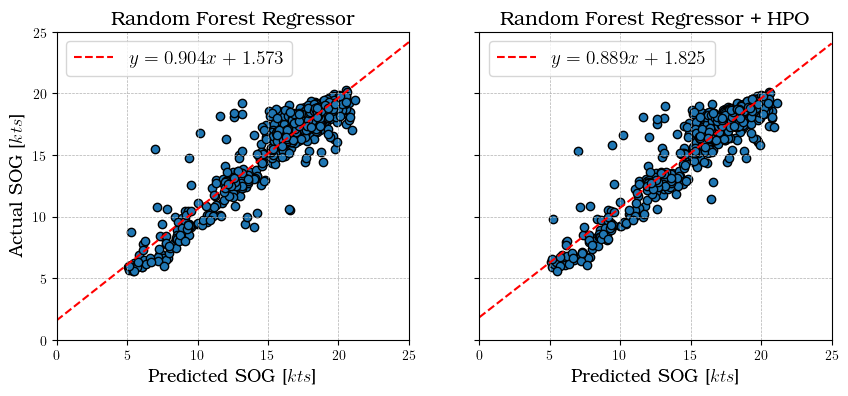

In [106]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9035679901216355
y = 0.9 * x + 1.5
0.9045206432177411
y = 0.9 * x + 1.6


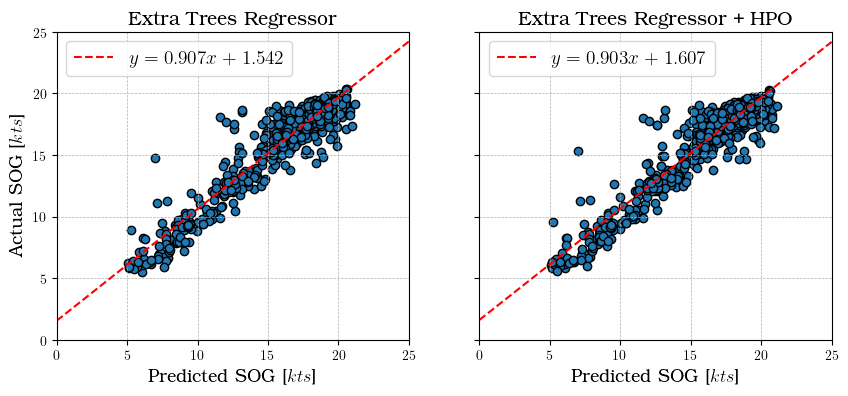

In [107]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

### Conversion to STW 
+ Considered only effect of current per [Kim20b](https://doi.org/10.1016/j.ijnaoe.2020.03.007)

In [108]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

#Test data

# ETR
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)

# RFR
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)


# DTR
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)

# MLR  
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
ydate_pred__mlr_yr = label_predict(model_mlr_ftr,x_date_yr)


# For actual results

# Yearly dataset

dfprog_sog_yr = pd.Series(y_date_yr,name="sog_act_yr").to_frame()
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)
ydate_pred_mlr_yr = label_predict(model_mlr_ftr,x_date_yr)
dfprog_sog_yr["sog_pred_yr"] = ydate_pred_yr
dfprog_sog_yr["sog_pred_rf_yr"] = ydate_pred_rf_yr
dfprog_sog_yr["sog_pred_dt_yr"] = ydate_pred_dt_yr
dfprog_sog_yr["sog_pred_mlr_yr"] = ydate_pred_mlr_yr
dfprog_sog_yr["gamma_yr"] = dfyear["truenorthcurrentdir"]
dfprog_sog_yr["nwinddir_yr"] = dfyear["truenorthwinddir"]
dfprog_yr = pd.concat([x_date_yr,dfprog_sog_yr],axis=1)


# Winter dataset
dfprog_sog_w = pd.Series(y_date_w,name="sog_act_w").to_frame()
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
dfprog_sog_w["sog_pred_w"] = ydate_pred_w
dfprog_sog_w["sog_pred_rf_w"] = ydate_pred_rf_w
dfprog_sog_w["sog_pred_dt_w"] = ydate_pred_dt_w
dfprog_sog_w["sog_pred_mlr_w"] = ydate_pred_mlr_w
dfprog_sog_w["gamma_w"] = dfwinter["truenorthcurrentdir"]
dfprog_sog_w["nwinddir_w"] = dfwinter["truenorthwinddir"]
dfprog_w = pd.concat([x_date_w,dfprog_sog_w],axis=1)

# Summer Dataset
dfprog_sog_s = pd.Series(y_date_s,name="sog_act_s").to_frame()
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
dfprog_sog_s["sog_pred_s"] = ydate_pred_s
dfprog_sog_s["sog_pred_rf_s"] = ydate_pred_rf_s
dfprog_sog_s["sog_pred_dt_s"] = ydate_pred_dt_s
dfprog_sog_s["sog_pred_mlr_s"] = ydate_pred_mlr_s
dfprog_sog_s["gamma_s"] = dfsummer["truenorthcurrentdir"]
dfprog_sog_s["nwinddir_s"] = dfsummer["truenorthwinddir"]
dfprog_s = pd.concat([x_date_s,dfprog_sog_s],axis=1)


In [109]:
dfprog_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_yr,sog_pred_yr,sog_pred_rf_yr,sog_pred_dt_yr,sog_pred_mlr_yr,gamma_yr,nwinddir_yr
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,282.945515,3.745513,283.817198,0.808538,5.187500,185.201229,175.649072,6.370372,0.085467,85.197483,84.424576,94.407976,16.808318,16.782244,16.767418,16.742992,16.612992,158.687531,198.459496
std,6.693964,0.852211,5.918176,0.551773,0.209903,86.903295,89.601309,3.046064,0.054757,56.311555,72.214559,55.255339,3.236891,3.072753,3.045732,3.074973,2.794555,100.130517,96.427800
min,265.853058,1.967748,273.048584,0.106645,4.700000,39.652335,36.754864,0.291621,0.002871,0.029187,0.211782,0.026438,5.051765,5.617114,5.620099,6.323533,2.487992,0.163419,0.045910
25%,277.026001,3.137187,278.277527,0.397821,5.000000,101.278890,99.296271,4.033796,0.042554,33.219213,12.681128,42.673743,16.226408,16.529083,16.495494,16.670793,16.920079,78.621852,126.654471
50%,282.977295,3.693673,283.452393,0.693676,5.200000,165.700352,122.921136,6.136388,0.072329,82.404607,44.663239,97.880895,17.944895,17.963684,17.989469,17.758421,17.578738,139.576787,204.223540
75%,289.193970,4.180873,289.408936,1.010680,5.383011,278.749187,275.572485,8.336454,0.114552,138.279377,167.111686,143.123608,18.796294,18.626781,18.563810,18.411265,17.967646,250.482886,281.950978
max,297.026611,6.929401,294.732666,3.496446,5.700000,311.866157,304.903786,15.897204,0.367573,179.155072,179.882682,179.802032,21.147826,20.308487,20.134377,19.963246,22.689761,359.985910,359.653531


In [110]:
dfprog_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_w,sog_pred_w,sog_pred_rf_w,sog_pred_dt_w,sog_pred_mlr_w,gamma_w,nwinddir_w
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,279.182176,3.754504,280.245181,0.783224,5.156086,191.133220,181.090320,6.556435,0.087990,82.739071,83.189784,96.253799,16.528842,16.563455,16.568837,16.580291,16.411529,147.071910,204.831080
std,5.270506,0.736301,4.452504,0.454025,0.201036,84.398913,88.688134,3.111650,0.055067,56.188314,75.144726,52.909591,3.250333,3.163793,3.161489,3.151202,2.828858,98.061688,92.150188
min,265.853058,2.118870,273.048584,0.106645,4.700000,39.652335,36.754864,0.427826,0.002871,0.029187,1.470000,0.055169,5.051765,5.599609,5.614914,6.323533,2.510980,0.163419,0.045910
25%,275.763489,3.264905,277.402771,0.446341,5.000000,104.174503,101.096372,4.141282,0.044775,31.399868,12.013374,47.409100,15.960062,16.467518,16.404816,16.280146,16.801508,72.917708,165.580446
50%,277.989624,3.728289,278.774841,0.731388,5.200000,161.132821,122.865257,6.366622,0.075156,81.457629,33.589579,100.127737,17.736217,17.839338,17.819834,17.758421,17.467883,126.988054,208.025298
75%,281.190063,4.179608,282.265167,0.968981,5.300000,280.022044,277.939682,8.451004,0.117231,134.869469,168.521519,141.588215,18.563067,18.446502,18.498945,18.411265,17.821189,204.435019,278.866914
max,293.066406,6.411206,292.665283,3.196778,5.700000,307.531280,304.903786,14.946484,0.367573,179.148714,179.814996,179.802032,20.506417,19.688435,19.781523,19.963246,23.308350,359.985910,359.653531


In [111]:
dfprog_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_s,sog_pred_s,sog_pred_rf_s,sog_pred_dt_s,sog_pred_mlr_s,gamma_s,nwinddir_s
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,286.004301,3.726736,286.686932,0.821881,5.213033,180.379793,171.226505,6.219143,0.083415,87.195644,85.428197,92.937584,17.035473,16.957326,16.930608,16.874292,16.779703,168.128538,193.280767
std,6.149459,0.934051,5.402507,0.618899,0.213613,88.658541,90.162220,2.985537,0.054460,56.375274,69.784060,56.881636,3.210503,2.992991,2.937742,3.010604,2.761861,100.873442,99.538946
min,269.218018,1.967748,274.747070,0.114266,4.700000,41.012784,38.133595,0.291621,0.004443,0.172495,0.211782,0.026438,5.121978,5.738418,5.916993,6.323533,2.880837,0.755572,1.235841
25%,282.958252,3.041207,283.398682,0.366759,5.000000,99.002926,97.273666,3.975014,0.041495,36.042219,14.185714,39.490445,16.328233,16.602272,16.626266,16.670793,17.022204,82.959063,102.302912
50%,287.809570,3.639042,287.945068,0.673662,5.200000,178.861429,123.147416,5.943068,0.068563,86.312881,48.651546,94.608401,18.163665,18.143633,18.097664,18.227261,17.678163,151.151144,201.419433
75%,290.848877,4.181604,291.150757,1.039653,5.400000,275.883815,273.227599,8.155920,0.113071,139.768694,164.741167,143.617027,18.987403,18.754925,18.633461,18.660831,18.056056,271.700617,283.274598
max,297.026611,6.929401,294.732666,3.496446,5.700000,311.866157,304.299694,15.897204,0.337454,179.155072,179.882682,179.600031,21.147826,20.308487,20.134377,19.963246,19.467048,359.937985,359.212674


In [112]:
# # Ignore for latex export
# print(dfprog_sog_s.describe())
# print(dfprog_sog_s.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

+ Boxplots showcasing the skew of the SOG

<Figure size 500x300 with 0 Axes>

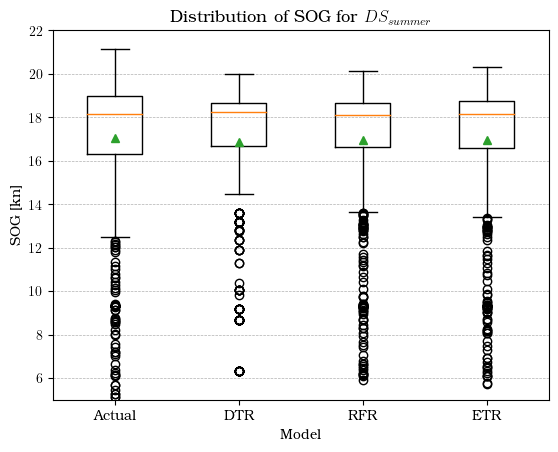

In [113]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_s['sog_act_s'],dfprog_sog_s['sog_pred_dt_s'],dfprog_sog_s['sog_pred_rf_s'],dfprog_sog_s['sog_pred_s']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{summer}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [114]:
# # Ignore for latex export
# print(dfprog_sog_w.describe())
# print(dfprog_sog_w.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# )) 

<Figure size 500x300 with 0 Axes>

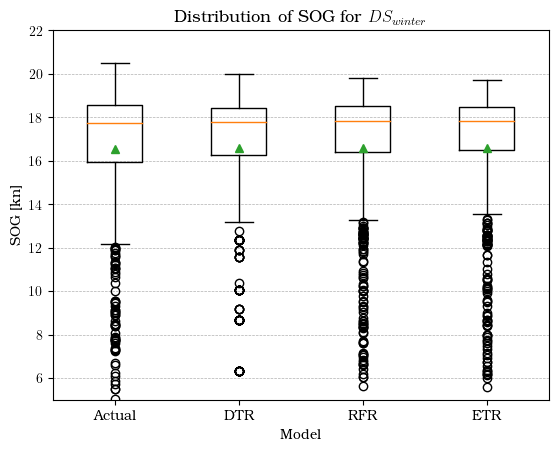

In [115]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_w['sog_act_w'],dfprog_sog_w['sog_pred_dt_w'],dfprog_sog_w['sog_pred_rf_w'],dfprog_sog_w['sog_pred_w']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{winter}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [116]:
# # Ignore for latex export
# print(dfprog_sog_yr.describe())
# print(dfprog_sog_yr.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# )) 

<Figure size 500x300 with 0 Axes>

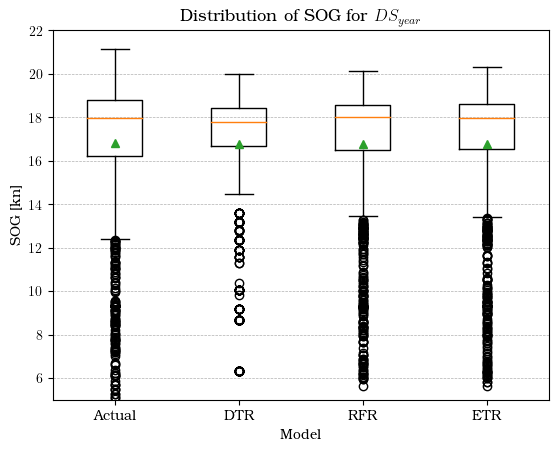

In [117]:
# Box plot of predicted results of yearly dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_yr['sog_act_yr'],dfprog_sog_yr['sog_pred_dt_yr'],dfprog_sog_yr['sog_pred_rf_yr'],dfprog_sog_yr['sog_pred_yr']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{year}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

Formula for STW correction

In [118]:
def sog_corr(sog,gamma,heading,current_speed):
    # Conversion of predicted SOG to m/s
    vgms = sog/1.9438
    rad_gamma = np.deg2rad(gamma)
    rad_cog = np.deg2rad(heading)
    # Calculation of the predicted x-component of SOG

    vgx = vgms * np.sin(rad_cog)
    vcx = current_speed * np.sin(rad_gamma)
    stw_x = vgx - vcx

    # Calculation of the predicted y-component of SOG 

    vgy = vgms * np.cos(rad_cog)
    vcy = current_speed * rad_gamma
    stw_y = vgy - vcy

    vwms_p = np.sqrt(stw_x**2 + stw_y**2)
    stw_pred = vwms_p*1.9438

    return stw_pred

In [119]:
# STW conversion Year

# Actual
stw_act_yr = sog_corr(dfprog_yr['sog_act_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_act_yr'] = stw_act_yr
# ETR
stw_pred_et_yr = sog_corr(dfprog_yr['sog_pred_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_yr'] = stw_pred_et_yr
# RFR
stw_pred_rf_yr = sog_corr(dfprog_yr['sog_pred_rf_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_rf_yr'] = stw_pred_rf_yr
# DTR
stw_pred_dt_yr = sog_corr(dfprog_yr['sog_pred_dt_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_dt_yr'] = stw_pred_dt_yr
# MLR
stw_pred_mlr_yr = sog_corr(dfprog_yr['sog_pred_mlr_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_mlr_yr'] = stw_pred_mlr_yr



In [120]:
print(dfprog_yr.describe())

       oceantemperature   waveperiod     surftemp  windwaveswellheight  \
count       1191.000000  1191.000000  1191.000000          1191.000000   
mean         282.945515     3.745513   283.817198             0.808538   
std            6.693964     0.852211     5.918176             0.551773   
min          265.853058     1.967748   273.048584             0.106645   
25%          277.026001     3.137187   278.277527             0.397821   
50%          282.977295     3.693673   283.452393             0.693676   
75%          289.193970     4.180873   289.408936             1.010680   
max          297.026611     6.929401   294.732666             3.496446   

           draught          cog      heading    windspeed     curspeed  \
count  1191.000000  1191.000000  1191.000000  1191.000000  1191.000000   
mean      5.187500   185.201229   175.649072     6.370372     0.085467   
std       0.209903    86.903295    89.601309     3.046064     0.054757   
min       4.700000    39.652335    36

In [121]:
# STW conversion Summer 

# Actual
stw_act_s = sog_corr(dfprog_s['sog_act_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_act_s'] = stw_act_s
# ETR
stw_pred_et_s = sog_corr(dfprog_s['sog_pred_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_s'] = stw_pred_et_s
# RFR
stw_pred_rf_s = sog_corr(dfprog_s['sog_pred_rf_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_rf_s'] = stw_pred_rf_s
# DTR
stw_pred_dt_s = sog_corr(dfprog_s['sog_pred_dt_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_dt_s'] = stw_pred_dt_s
# MLR
stw_pred_mlr_s = sog_corr(dfprog_s['sog_pred_mlr_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_mlr_s'] = stw_pred_mlr_s



In [122]:
print(dfprog_s.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        657.000000  657.000000  657.000000           657.000000   
mean         286.004301    3.726736  286.686932             0.821881   
std            6.149459    0.934051    5.402507             0.618899   
min          269.218018    1.967748  274.747070             0.114266   
25%          282.958252    3.041207  283.398682             0.366759   
50%          287.809570    3.639042  287.945068             0.673662   
75%          290.848877    4.181604  291.150757             1.039653   
max          297.026611    6.929401  294.732666             3.496446   

          draught         cog     heading   windspeed    curspeed  \
count  657.000000  657.000000  657.000000  657.000000  657.000000   
mean     5.213033  180.379793  171.226505    6.219143    0.083415   
std      0.213613   88.658541   90.162220    2.985537    0.054460   
min      4.700000   41.012784   38.133595    0.291621    0.004443   
25%   

In [123]:
# STW conversion Winter

# Actual
stw_act_w = sog_corr(dfprog_w['sog_act_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_act_w'] = stw_act_w
# ETR
stw_pred_et_w = sog_corr(dfprog_w['sog_pred_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_w'] = stw_pred_et_w
# RFR
stw_pred_rf_w = sog_corr(dfprog_w['sog_pred_rf_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_rf_w'] = stw_pred_rf_w
# DTR
stw_pred_dt_w = sog_corr(dfprog_w['sog_pred_dt_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_dt_w'] = stw_pred_dt_w
# MLR
stw_pred_mlr_w = sog_corr(dfprog_w['sog_pred_mlr_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_mlr_w'] = stw_pred_mlr_w

Holtrop Mennen FOC function

In [124]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots
    # V_n = 18 # ship design speed, knots


    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    # V_n = 18/1.94384

    Fr_n = V_n / math.sqrt(g*lwl)
    # print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    # print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    # print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    # print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    # print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    
    # print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # print(f"lcb {lcb:0.4f}")

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))

    # print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

    # print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    # print(f"Mean Reynold Number {Re.mean():0.2f}")
    # print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    # print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    # Borrow estimation of Am from Guldahmmer and Harvald
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    # print(f"A_m {A_m:0.2f} m^2")
    # print(f"A_t {A_t:0.4f} m^2")
    # print(f"A_bt {A_bt:0.4f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    # print(f"S_bh {S_bh.mean():0.4f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    # print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = 2*math.pi * D_shaft * l_shaft
    k2_shaft = 3   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side (triangle)
    k2_skeg = 1.5

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    # print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    # print(f"(1+k2) equivalent {k2_const:0.2f}")
    # print(f"Total Appendage area is {S_app:0.4f}")
    # # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth

    # print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    # print(f"B/lwl = {B/lwl:0.2f}")
    # print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    # print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke
    
    # print(f"h_B {h_b:0.4f}")

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lwl)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # print(f"i_e = {i_e:0.4f}")

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)

    # print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    # print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))

    # print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    # print(f"C_a {C_a.mean()}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    # print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = (1/16) * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl) * B

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    # print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    R_tot = (R_f + R_app + R_w + R_b + R_a + R_tr  + R_aa + R_awl)/1e3 

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer
    PD_const = 1.135  # From Bertram

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*PD_const
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.7 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    # print(f"Total Efficiency {eff_tot.mean():0.3f}")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h
    FOC_day = FOC * 11 #Per day 11 hour journey

    # print("Summary of important results")
    
    # print(f"Ship Displacement {dsp:0.4f} m^3")
    # print(f"Prismatic coefficient C_p {C_p:0.4f}")
    # print(f"Midship coefficient C_m {C_m:0.4f}")
    # print(f"Block coefficient C_b {C_b:0.4f}")
    # print(f"Waterplane area constant C_wp {C_wp:0.4f}")
    # print(f"Design Froude Number Fr_n {Fr_n:0.4f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Max STW {stw.max():0.2f} kt")
    # print(f"Average frictional Resistance R_f {R_f.mean()/1e3:0.3f}kN")
    # print(f"Average appendage friction R_app {R_app.mean()/1e3:0.3f}kN")
    # print(f"Average wave making (calm) resistance R_w {R_w.mean()/1e3:0.3f}kN")
    # print(f"Average bulbous bow resistance R_b {R_b.mean()/1e3:0.3f}kN")
    # print(f"Average transom resistance R_t {R_tr.mean()/1e3:0.3f}kN")
    # print(f"Average model correlation resistance R_a {R_a.mean()/1e3:0.3f}kN")
    # print(f"Average wind resistance (Blendermann) R_aa {R_aa.mean()/1e3:0.3f}kN")
    # print(f"Average wave resistance R_awl {R_awl.mean()/1e3:0.3f}kN")
    # print(f"Average total resistance R_tot {R_tot.mean():0.3f}kN")
    # print(f"Average Total Efficiency {eff_tot.mean():0.3f}")
    # print(f"Average Power {P_b.mean():0.3f} kW")
    # print(f"Max Power {P_b.max():0.3f} kW")
    # print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")
    # print(f"Average Fuel Consumption per day {FOC_day.mean():0.3f} T")


    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,R_tot,eff_tot,P_b,FOC


Comparison of Summer and Winter fuel consumption

Actual Summer

In [125]:
Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s = foc_fun(dfprog_s['stw_act_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [126]:
def stats_HoltropMennen(stw,RFric,RApp,RWave,RBulb,RTrans,RCorr,RWind,RStaWave,RTot,EffTot,Pbrake,FOChr):
    WBM_desc_stats = pd.concat([stw,RFric/1e3,RApp/1e3,RWave/1e3,RBulb/1e3,pd.Series(RTrans/1e3),RCorr/1e3,RWind/1e3,pd.Series(RStaWave/1e3),RTot,EffTot,Pbrake,FOChr],axis=1)
    WBM_HM_desc = pd.DataFrame(WBM_desc_stats)
    WBM_HM_desc.columns = ['STW [m/s]','R_F [kN]', 'R_APP [kN]', 'R_W [kN]', 'R_B [kN]', 'R_TR [kN]' ,'R_A [kN]', 'R_AA [kN]' , 'R_AWL [kN]', 'R_TOT [kN]' , 'EFF_TOT [-]' ,'P_B[kW]','FOC [T/h]' ]
    # Direct print to LaTex, uncomment if needed
    # print(WBM_HM_desc.describe().transpose().to_latex(index=False,

    #               formatters={"name": str.upper},

    #               float_format="{:.2f}".format,
    # ))
    return WBM_HM_desc 


In [127]:
WBM_act_s = stats_HoltropMennen(stw_act_s,Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s)

In [128]:
WBM_act_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,17.081260,175.519907,39.791731,100.993498,70.900858,5.815990,44.741736,12.304790,4.666675,454.735184,0.666668,6316.450996,1.070007
std,3.166074,51.589112,11.889100,63.314115,11.636111,11.513334,13.523205,10.705090,15.583850,139.990148,0.000301,2590.238412,0.438786
min,5.070327,16.918489,3.543241,0.000030,17.558107,0.000000,3.811982,0.003914,0.000000,102.916419,0.665948,402.152149,0.068125
25%,16.358397,156.591629,35.385988,54.440913,68.652535,0.000000,39.689350,3.804818,0.000000,380.255939,0.666419,4854.318954,0.822322
50%,18.107645,189.040152,43.213892,103.261569,74.480039,0.000000,48.587904,9.549170,0.000000,479.231032,0.666705,6662.861722,1.128689
75%,19.022932,208.732793,47.616367,139.714716,78.080552,5.830977,53.714444,17.702231,0.928840,544.379645,0.666882,8014.348123,1.357631
max,21.669258,271.688059,61.526716,340.747208,83.914300,53.850735,69.819025,54.397739,140.787839,872.996396,0.667676,14596.749885,2.472689


Actual Winter

In [129]:
Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w = foc_fun(dfprog_w['stw_act_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [130]:
WBM_act_w = stats_HoltropMennen(stw_act_w,Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w)

In [131]:
WBM_act_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,16.540628,164.936741,37.476060,84.240185,70.717356,7.023625,42.066006,12.949604,1.933058,421.342635,0.666623,5683.957503,0.962862
std,3.222851,51.062966,11.789700,52.134093,11.643215,12.376575,13.389273,11.327132,5.749432,128.026369,0.000289,2326.678415,0.394139
min,5.087667,16.900585,3.567058,0.000034,16.361839,0.000000,3.831719,0.001398,0.000000,102.229512,0.665954,431.792259,0.073146
25%,15.886848,149.541924,33.407660,44.099359,68.958010,0.000000,37.437863,4.034585,0.000000,357.403251,0.666409,4364.895719,0.739413
50%,17.708064,181.363681,41.357937,90.216348,75.193098,0.089457,46.442223,9.904001,0.000000,452.084803,0.666622,6167.587206,1.044789
75%,18.574461,199.370692,45.432964,119.793104,77.733583,7.836959,51.175017,19.319375,0.000000,508.636153,0.666814,7323.412531,1.240586
max,20.516327,239.514550,55.250730,233.169289,83.053661,53.776969,62.309675,55.123446,64.652041,695.642783,0.667709,11017.684408,1.866396


Actual Year

In [132]:
Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr = foc_fun(dfprog_yr['stw_act_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [133]:
WBM_act_yr = stats_HoltropMennen(stw_act_yr,Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr)

In [134]:
WBM_act_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,16.838860,170.774810,38.753470,93.481937,70.818583,6.357448,43.542038,12.593901,3.440755,439.762942,0.666648,6032.946788,1.021981
std,3.201629,51.601690,11.895592,59.132710,11.634763,11.918195,13.523359,10.988358,12.272943,135.753864,0.000297,2494.725118,0.422606
min,5.070327,16.900585,3.543241,0.000030,16.361839,0.000000,3.811982,0.001398,0.000000,102.229512,0.665948,402.152149,0.068125
25%,16.144962,153.830832,34.483602,49.889566,68.795063,0.000000,38.731871,3.895099,0.000000,370.472658,0.666416,4616.397597,0.782018
50%,17.895087,185.321458,42.221613,96.502530,74.918136,0.000000,47.432993,9.778744,0.000000,465.638913,0.666670,6435.174853,1.090119
75%,18.803353,204.286041,46.541029,129.735346,77.952031,6.738936,52.426847,18.693497,0.518015,526.107177,0.666846,7635.917346,1.293524
max,21.669258,271.688059,61.526716,340.747208,83.914300,53.850735,69.819025,55.123446,140.787839,872.996396,0.667709,14596.749885,2.472689


ETR Year

In [135]:
Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr = foc_fun(dfprog_yr['stw_pred_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [136]:
WBM_etr_yr = stats_HoltropMennen(stw_pred_et_yr,Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr)

In [137]:
WBM_etr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,16.812750,169.757743,38.510487,88.357848,70.887973,5.929306,43.259779,12.540189,3.440755,432.684080,0.666647,5885.770345,0.997049
std,3.037781,48.260944,11.116951,48.163397,11.209023,11.710237,12.628647,10.972449,12.272943,120.740601,0.000293,2184.323926,0.370024
min,5.728648,21.330280,4.502413,0.000302,20.018735,0.000000,4.866125,0.017281,0.000000,110.535638,0.665954,492.267880,0.083390
25%,16.436313,159.240223,35.718274,56.580196,69.149514,0.000000,40.142392,3.794333,0.000000,377.971836,0.666426,4812.305991,0.815205
50%,17.955208,186.095452,42.501123,98.300470,74.817007,0.000000,47.801523,9.787978,0.000000,467.354510,0.666681,6481.387154,1.097947
75%,18.628988,200.405791,45.695739,122.075998,77.817122,5.499521,51.425743,18.425420,0.518015,512.813242,0.666839,7402.310314,1.253951
max,21.163471,259.735900,58.732508,297.083352,82.965693,51.050218,66.597740,55.812224,140.787839,809.238154,0.667620,13214.566765,2.238548


ETR summer

In [138]:
Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s = foc_fun(dfprog_s['stw_pred_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [139]:
WBM_etr_s = stats_HoltropMennen(stw_pred_et_s,Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s)

In [140]:
WBM_etr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,17.003077,173.360041,39.279946,93.057462,70.893874,5.482427,44.151395,12.180368,4.666675,443.072189,0.666668,6078.411222,1.029683
std,2.951047,47.446981,10.927347,50.326787,11.041358,11.147190,12.419992,10.592475,15.583850,121.846231,0.000296,2217.665378,0.375673
min,5.669100,20.911305,4.411012,0.000250,20.084705,0.000000,4.765485,0.001371,0.000000,110.676517,0.665954,483.611736,0.081924
25%,16.576026,160.537826,36.317928,59.713062,68.744326,0.000000,40.813731,3.455880,0.000000,389.501687,0.666432,4959.806142,0.840191
50%,18.110602,189.173375,43.227777,102.512812,74.288773,0.000000,48.590735,9.769600,0.000000,476.600768,0.666702,6664.240755,1.128922
75%,18.768770,203.711401,46.372768,128.182431,77.941969,4.905178,52.298584,18.002963,0.928840,525.053097,0.666880,7593.275089,1.286301
max,21.163471,259.735900,58.732508,297.083352,82.965693,51.303539,66.597740,53.517011,140.787839,809.238154,0.667619,13214.566765,2.238548


ETR winter

In [141]:
Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w = foc_fun(dfprog_w['stw_pred_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [142]:
WBM_etr_w = stats_HoltropMennen(stw_pred_et_w,Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w)

In [143]:
WBM_etr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,16.575207,165.283692,37.554035,82.547442,70.864172,6.491661,42.151831,12.986623,1.933058,419.812515,0.666621,5646.999037,0.956602
std,3.134164,48.980102,11.296908,44.729986,11.447078,12.383148,12.821299,11.416348,5.749432,118.232573,0.000288,2121.096676,0.359314
min,5.981779,23.104305,4.901221,0.000649,21.030558,0.000000,5.303163,0.020923,0.000000,110.292240,0.665955,512.098139,0.086749
25%,16.341654,156.730257,35.314789,54.042430,69.722803,0.000000,39.596260,3.911177,0.000000,374.024142,0.666423,4701.542873,0.796441
50%,17.833630,183.810878,41.936830,94.081943,75.293626,0.000000,47.136136,9.842465,0.000000,457.373203,0.666618,6309.844398,1.068888
75%,18.466633,195.748901,44.915528,114.848237,77.704722,5.902201,50.473586,19.364406,0.000000,498.552257,0.666806,7084.887376,1.200180
max,20.029516,237.261749,52.700698,207.691839,80.991888,49.973394,59.788951,55.812224,64.652041,654.657522,0.667603,10113.652406,1.713253


RFR year

In [144]:
Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr = foc_fun(dfprog_yr['stw_pred_rf_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [145]:
WBM_rfr_yr = stats_HoltropMennen(stw_pred_rf_yr,Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr)

In [146]:
WBM_rfr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,16.797937,169.392921,38.426026,87.347705,70.871785,5.912908,43.162349,12.512879,3.440755,431.067328,0.666647,5853.524759,0.991587
std,3.011892,47.770674,11.011249,46.595427,11.137668,11.668123,12.505704,10.933045,12.272943,118.662182,0.000293,2141.735286,0.362810
min,5.869378,22.336102,4.722080,0.000463,19.406738,0.000000,5.108144,0.011687,0.000000,110.577201,0.665950,513.132952,0.086925
25%,16.389639,158.121807,35.519043,55.165499,69.130140,0.000000,39.820061,3.807462,0.000000,377.160357,0.666430,4777.528647,0.809313
50%,17.972739,186.699920,42.582796,98.564558,74.790314,0.000000,47.803488,9.734599,0.000000,467.006719,0.666686,6490.947994,1.099567
75%,18.571775,199.639022,45.420037,120.476113,77.954530,5.698073,51.167355,18.352371,0.518015,509.793288,0.666844,7303.310338,1.237181
max,20.689441,248.766900,56.171850,255.915188,82.418472,50.451549,63.647772,55.315860,140.787839,749.558758,0.667634,11965.600710,2.026973


RFR Summer


In [147]:
Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s = foc_fun(dfprog_s['stw_pred_rf_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [148]:
WBM_rfr_s = stats_HoltropMennen(stw_pred_rf_s,Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s)

In [149]:
WBM_rfr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,16.976385,172.687087,39.122330,91.161660,70.877251,5.418012,43.969801,12.131293,4.666675,440.034109,0.666669,6017.344212,1.019338
std,2.897046,46.458011,10.704605,47.854465,10.914819,11.043234,12.163925,10.515253,15.583850,118.197755,0.000295,2144.118458,0.363214
min,5.847539,22.178568,4.687653,0.000433,20.249551,0.000000,5.070200,0.001298,0.000000,113.118173,0.665950,509.857155,0.086370
25%,16.560162,161.459024,36.249591,59.273454,68.885744,0.000000,40.675870,3.502329,0.000000,390.134108,0.666432,4980.289693,0.843661
50%,18.096827,189.381479,43.163117,101.870898,74.297317,0.000000,48.445272,9.655545,0.000000,476.186682,0.666704,6629.235842,1.122993
75%,18.664934,201.661256,45.869373,124.008185,77.965508,4.972664,51.687607,17.902854,0.928840,516.831100,0.666878,7472.059905,1.265767
max,20.689441,248.766900,56.171850,255.915188,82.418472,50.544455,63.647772,53.205398,140.787839,749.558758,0.667615,11965.600710,2.026973


RFR winter

In [150]:
Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w = foc_fun(dfprog_w['stw_pred_rf_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [151]:
WBM_rfr_w = stats_HoltropMennen(stw_pred_rf_w,Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w)

In [152]:
WBM_rfr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,16.580582,165.370747,37.576231,82.669024,70.874229,6.512528,42.176739,12.991067,1.933058,420.103623,0.666621,5652.890892,0.957600
std,3.133037,49.038603,11.319583,44.585695,11.390863,12.363528,12.845533,11.418115,5.749432,118.258195,0.000288,2121.658361,0.359409
min,5.991818,23.224506,4.917381,0.000661,20.518908,0.000000,5.323265,0.016485,0.000000,110.505029,0.665955,514.390694,0.087138
25%,16.329806,156.676386,35.264441,54.020973,69.682758,0.000000,39.604760,4.014262,0.000000,373.399524,0.666426,4667.179398,0.790620
50%,17.865083,184.651300,42.082462,94.934430,75.427485,0.000000,47.324263,9.913071,0.000000,460.658646,0.666618,6331.630332,1.072578
75%,18.493078,196.959886,45.042164,116.191191,77.934932,5.952606,50.578886,19.482141,0.000000,501.736047,0.666806,7158.366316,1.212627
max,19.916621,234.721262,52.117809,199.400053,80.755765,49.930687,59.116859,55.315860,64.652041,642.148952,0.667614,9864.439384,1.671036


DTR Yearly

In [153]:
Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr = foc_fun(dfprog_yr['stw_pred_dt_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [154]:
WBM_dtr_yr = stats_HoltropMennen(stw_pred_dt_yr,Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr)

In [155]:
WBM_dtr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,16.773537,169.022654,38.341259,87.362205,70.788821,6.052237,43.066318,12.496884,3.440755,430.571134,0.666648,5846.356233,0.990373
std,3.040274,48.300917,11.137607,48.080894,11.252224,11.732126,12.650098,10.954851,12.272943,121.198170,0.000294,2191.650278,0.371266
min,6.246465,24.826997,5.336020,0.001287,19.782799,0.000000,5.793911,0.001503,0.000000,110.625736,0.665938,538.231593,0.091176
25%,16.512296,160.153517,36.043785,58.418596,69.018071,0.000000,40.495993,3.784657,0.000000,385.279875,0.666419,4938.133693,0.836520
50%,17.912446,186.723349,42.302225,97.007029,74.848570,0.000000,47.530057,9.752546,0.000000,464.639490,0.666675,6462.119407,1.094683
75%,18.550628,198.439682,45.318346,118.874208,77.910901,5.176287,50.999358,18.416255,0.518015,506.819133,0.666844,7273.256816,1.232090
max,20.600618,250.312733,55.698298,253.927935,82.316856,48.847410,63.247089,55.202017,140.787839,742.456898,0.667670,11797.419018,1.998483


DTR summer

In [156]:
Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s = foc_fun(dfprog_s['stw_pred_dt_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [157]:
WBM_dtr_s = stats_HoltropMennen(stw_pred_dt_s,Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s)

In [158]:
WBM_dtr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,16.920130,171.829496,38.926816,90.755762,70.667229,5.652563,43.747861,12.075805,4.666675,438.322207,0.666672,5988.939548,1.014526
std,2.967494,47.496243,10.949135,49.289579,11.241257,11.310688,12.440564,10.524272,15.583850,121.653092,0.000299,2206.709050,0.373817
min,6.246465,25.195475,5.336020,0.001287,19.782799,0.000000,5.793911,0.018388,0.000000,110.625736,0.665938,538.231593,0.091176
25%,16.736085,161.980812,37.010953,63.314729,68.544546,0.000000,41.452638,3.575400,0.000000,395.332763,0.666419,5107.720212,0.865248
50%,18.094831,189.930130,43.153754,103.081385,74.361989,0.000000,48.413898,9.620459,0.000000,477.506651,0.666705,6634.927869,1.123957
75%,18.624072,199.978830,45.672013,121.176173,77.948756,4.224284,51.359720,17.830751,0.928840,513.617108,0.666884,7384.355956,1.250910
max,20.600618,250.312733,55.698298,253.927935,82.042463,48.847410,63.247089,53.093495,140.787839,742.456898,0.667670,11797.419018,1.998483


DTR Winter

In [159]:
Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w = foc_fun(dfprog_w['stw_pred_dt_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [160]:
WBM_dtr_w = stats_HoltropMennen(stw_pred_dt_w,Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w)

In [161]:
WBM_dtr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,16.592034,165.558686,37.618517,83.197785,70.931433,6.548841,42.225228,13.016653,1.933058,421.030201,0.666620,5670.777225,0.960630
std,3.124174,49.137729,11.343183,46.243813,11.289936,12.238195,12.875679,11.450962,5.749432,120.050501,0.000287,2162.274881,0.366289
min,6.264345,24.826997,5.366045,0.001394,21.233348,0.000000,5.818515,0.001503,0.000000,111.513992,0.665959,541.566025,0.091741
25%,16.302778,156.429119,35.149729,53.151656,69.218325,0.000000,39.424506,4.042571,0.000000,373.905974,0.666417,4669.820437,0.791068
50%,17.812011,184.708404,41.836877,94.491285,75.155727,0.000000,47.092583,9.932484,0.000000,454.449638,0.666618,6260.655142,1.060555
75%,18.480501,197.468493,44.981915,116.212952,77.888577,6.067584,50.561421,19.160995,0.000000,498.634083,0.666798,7125.448790,1.207051
max,20.070824,233.866884,52.914776,200.015151,82.316856,48.771350,59.633004,55.202017,64.652041,646.488772,0.667599,10016.624707,1.696816


MLR Yearly data

In [162]:
Rf_pred_mlr_yr,R_app_pred_mlr_yr,R_w_pred_mlr_yr,R_b_pred_mlr_yr,R_tr_pred_mlr_yr,R_a_pred_mlr_yr,R_aa_pred_mlr_yr,R_awl_pred_mlr_yr,R_tot_pred_mlr_yr,eff_tot_pred_mlr_yr,P_b_pred_mlr_yr,FOC_pred_mlr_yr = foc_fun(dfprog_yr['stw_pred_mlr_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

MLR Summer

In [163]:
Rf_pred_mlr_s,R_app_pred_mlr_s,R_w_pred_mlr_s,R_b_pred_mlr_s,R_tr_pred_mlr_s,R_a_pred_mlr_s,R_aa_pred_mlr_s,R_awl_pred_mlr_s,R_tot_pred_mlr_s,eff_tot_pred_mlr_s,P_b_pred_mlr_s,FOC_pred_mlr_s = foc_fun(dfprog_s['stw_pred_mlr_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

MLR Winter

In [164]:
Rf_pred_mlr_w,R_app_pred_mlr_w,R_w_pred_mlr_w,R_b_pred_mlr_w,R_tr_pred_mlr_w,R_a_pred_mlr_w,R_aa_pred_mlr_w,R_awl_pred_mlr_w,R_tot_pred_mlr_w,eff_tot_pred_mlr_w,P_b_pred_mlr_w,FOC_pred_mlr_w = foc_fun(dfprog_w['stw_pred_mlr_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Best fit of results using polynomial regression

In [165]:
# Function to check possible best fit of polynomial regression

def poly_reg_best_fit(DataSet,STW,FOC):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from matplotlib.ticker import MultipleLocator,FixedLocator
    from matplotlib.transforms import ScaledTranslation

    plt.rcParams['figure.dpi'] = 300

    sorted_Xreg = np.sort(STW)
    sorted_Yreg = np.sort(FOC)

    Xreg = sorted_Xreg.reshape(-1,1)
    Yreg = sorted_Yreg

    Xreg_train, Xreg_test, Yreg_train, Yreg_test = train_test_split(Xreg, Yreg, test_size=0.25, random_state=42)

    train_errors = []
    test_errors = []
    coefficients_list = []
    scores_poly = []


    # Loop through different orders
    for order in range(1, 6):
        # Create polynomial features for the current order
        poly = PolynomialFeatures(degree=order)
        X_poly_train = poly.fit_transform(Xreg_train)
        X_poly_test = poly.transform(Xreg_test)

        # Fit the linear regression model
        model = LinearRegression()
        model.fit(X_poly_train, Yreg_train)

        # Make predictions on training and test data
        y_pred_train = model.predict(X_poly_train)
        y_pred_test = model.predict(X_poly_test)

        # Calculate the score (R-squared) of the model
        score = model.score(X_poly_test, Yreg_test)

        # Calculate mean squared errors for training and test data
        train_error = mean_squared_error(Yreg_train, y_pred_train)
        test_error = mean_squared_error(Yreg_test, y_pred_test)

        # Append the errors to the lists
        train_errors.append(train_error)
        test_errors.append(test_error)
        coefficients_list.append(model.coef_)
        scores_poly.append(score)
        # # Uncomment to get each order's performance
        # print(score)
        # print(test_error)
    
    # # Find the best model (lowest test error)
    
    # best_order = np.argmin(test_errors)
    
    # Brute force, seems that there is a bug with summer dataset actual dataset, in general order 4 is the most acceptable performance  
    best_order = 4
    
    best_coefficients = coefficients_list[best_order]

    # Create polynomial features for the best model
    poly = PolynomialFeatures(degree=best_order)
    X_poly = poly.fit_transform(Xreg)

    # Fit the best model on the entire dataset
    best_model = LinearRegression()
    best_model.fit(X_poly, Yreg)

    # Get coefficients of the best model
    coefficients = best_model.coef_
    intercept = best_model.intercept_

    # # Print the polynomial equation
    # equation = "y = {:.4f}".format(best_model.intercept_)
    # for i, coef in enumerate(best_coefficients[1:], 1):
    #     equation += " + {:.4f}x^{}".format(coef, i)

    # print("Best Polynomial Equation:")
    # print(equation)

    # LaTeX format for polynomial equation
    def format_equation(coefficients, intercept):
        equation = f"$y = {intercept:.4f}"
        for i, coef in enumerate(coefficients[1:], 1):
            equation += f" + ({coef:.4f})x^{i}"
        equation += "$"
        return equation
    
    # Print the best polynomial equation
    equation = format_equation(coefficients, intercept)
    print("Best Polynomial Equation:")
    print(equation)
    # print(score.max())
    # get score for the 4th order
    Rsquared = scores_poly[3]

    # Generate points for plotting the best-fitted line
    X_plot = np.linspace(Xreg.min(), Xreg.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = best_model.predict(X_plot_poly)

    # Plot the original data points and the best-fitted line
    # Follow definition from 3rd GHG study
    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # Actual Plot
    plt.scatter(STW, FOC,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    # # # Temporary plot for actual STW 
    # plt.scatter(STW, FOC,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12)
    plt.plot(X_plot, y_plot, color='black',label='Regression',linewidth=.8)
    plt.title(f'Regression fit for ${DataSet}$')
    plt.xlabel('STW [kn]')
    plt.ylabel('FOC [T/h]')
    # plt.xticks(range(6, 22, 1))
    plt.xlim(5,21)
    plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=0.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=0.6,fontsize=6)
    plt.text(4.2, -.25, equation, bbox=dict(facecolor='white', alpha=0.9),fontsize=12)
    plt.text(5.6, 1.5, rf'$R^2$ = {Rsquared:0.4f}', bbox=dict(facecolor='white', alpha=0.9),fontsize=14)

    # plt.grid(linestyle = '--', linewidth = 0.25,which='both')
    plt.legend(loc='upper left')
    # plt.show()
    
    return best_model


Scatter plot actual predicted FOC

In [166]:
def FOC_coeff_plot(model,stw_predicted,stw_actual,FOC_predicted,FOC_actual):
    from matplotlib.ticker import MultipleLocator,FixedLocator


    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # To predict FOC

    Xp = stw_predicted
    Yp = FOC_predicted

    Xa = stw_actual
    Ya = FOC_actual

    plt.scatter(Xa, Ya,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12,alpha=0.5)
    plt.scatter(Xp, Yp,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    plt.title(f"FOC Plot {model}")
    plt.xlabel(r'STW [$kn$]', fontsize=13)
    plt.ylabel(r'FOC [$T/h$]', fontsize=13)

    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)


    # plt.xlim(5,21)
    # plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    # plt.grid(linestyle = '--', linewidth = 0.5)
    # plt.legend(bbox_to_anchor=(0.5,-.4),loc="lower left")
    plt.legend()
    # plt.show()

Plot of predicted vs actual

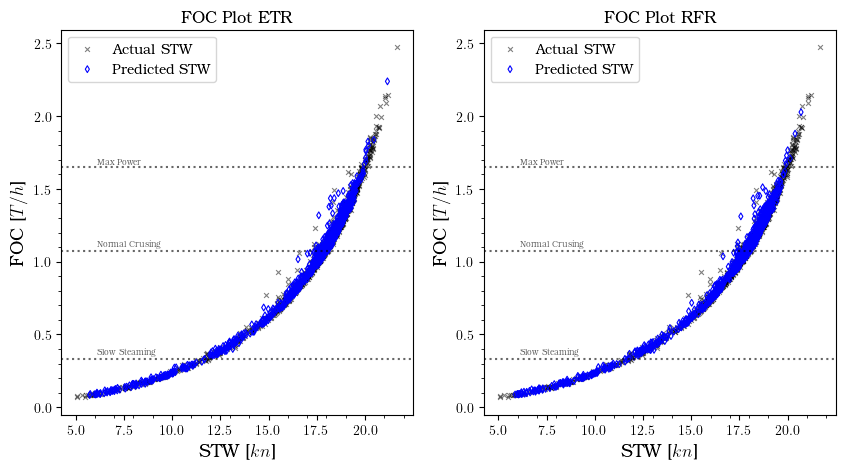

In [167]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('ETR',stw_pred_et_yr,stw_act_yr,FOC_pred_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('RFR',stw_pred_rf_yr,stw_act_yr,FOC_pred_rf_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

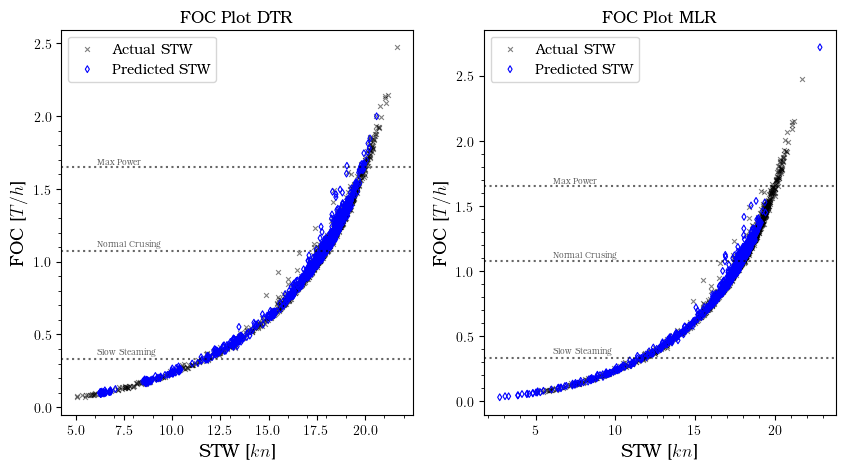

In [168]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('DTR',stw_pred_dt_yr,stw_act_yr,FOC_pred_dt_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('MLR',stw_pred_mlr_yr,stw_act_yr,FOC_pred_mlr_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

Actual data polyfit

Best Polynomial Equation:
$y = 0.8116 + (-0.3190)x^1 + (0.0478)x^2 + (-0.0028)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.5921 + (-0.2390)x^1 + (0.0376)x^2 + (-0.0023)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.9157 + (-0.3568)x^1 + (0.0525)x^2 + (-0.0031)x^3 + (0.0001)x^4$


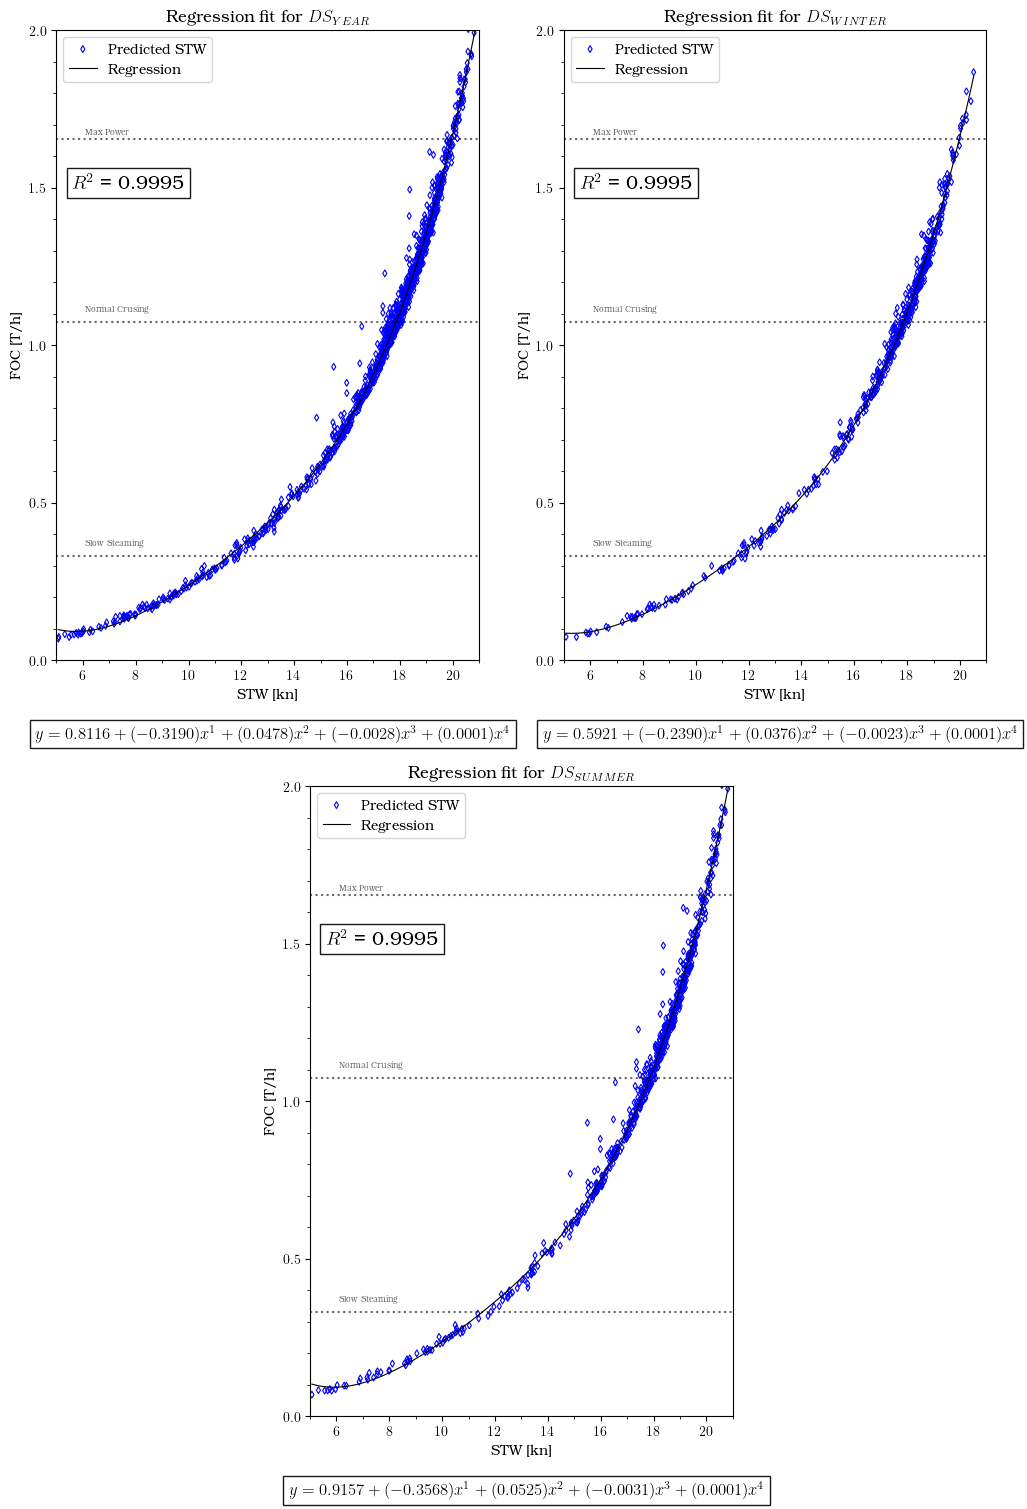

In [169]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_act_yr = poly_reg_best_fit('DS_{YEAR}',stw_act_yr,FOC_act_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_act_s = poly_reg_best_fit('DS_{WINTER}',stw_act_w,FOC_act_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_act_w = poly_reg_best_fit('DS_{SUMMER}',stw_act_s,FOC_act_s)
plt.show()

ETR polyfit plot

Best Polynomial Equation:
$y = 0.9081 + (-0.3487)x^1 + (0.0512)x^2 + (-0.0030)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.8559 + (-0.3329)x^1 + (0.0497)x^2 + (-0.0030)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.9443 + (-0.3601)x^1 + (0.0524)x^2 + (-0.0031)x^3 + (0.0001)x^4$


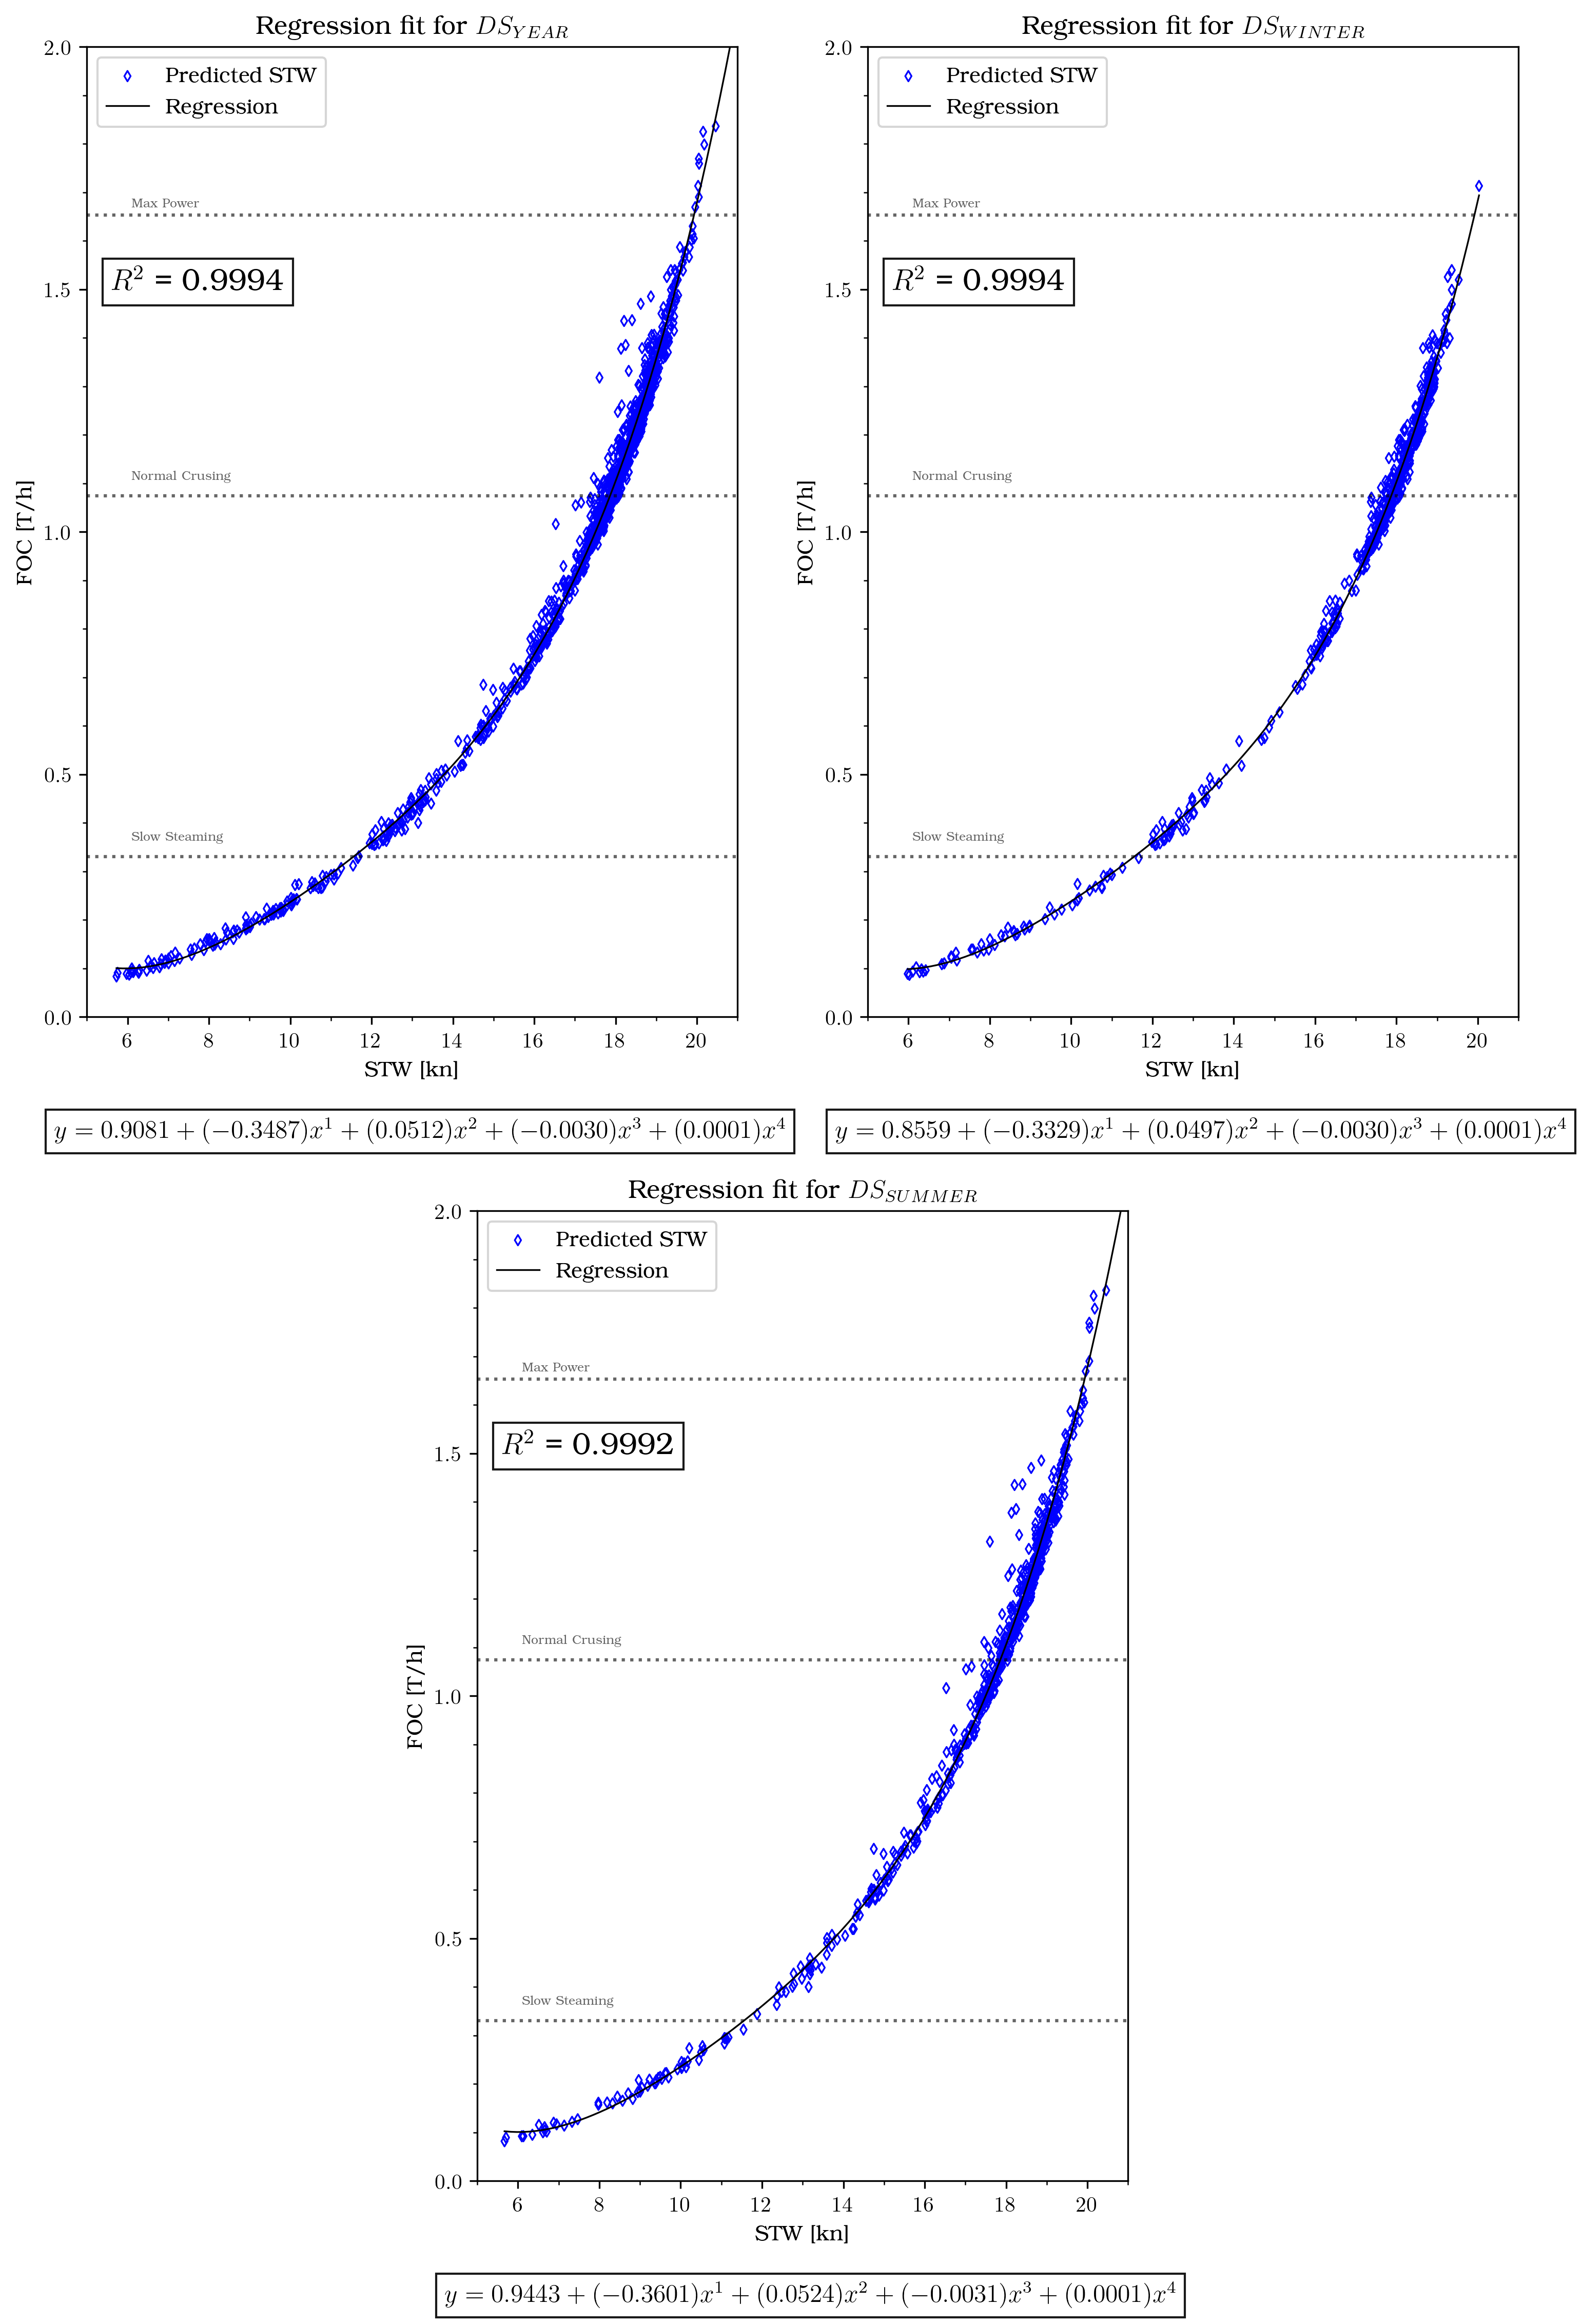

In [170]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_etr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_et_yr,FOC_pred_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_etr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_et_w,FOC_pred_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_etr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_et_s,FOC_pred_s)
plt.show()

RFR polyfit FOC

Best Polynomial Equation:
$y = 0.9873 + (-0.3777)x^1 + (0.0551)x^2 + (-0.0032)x^3 + (0.0001)x^4$


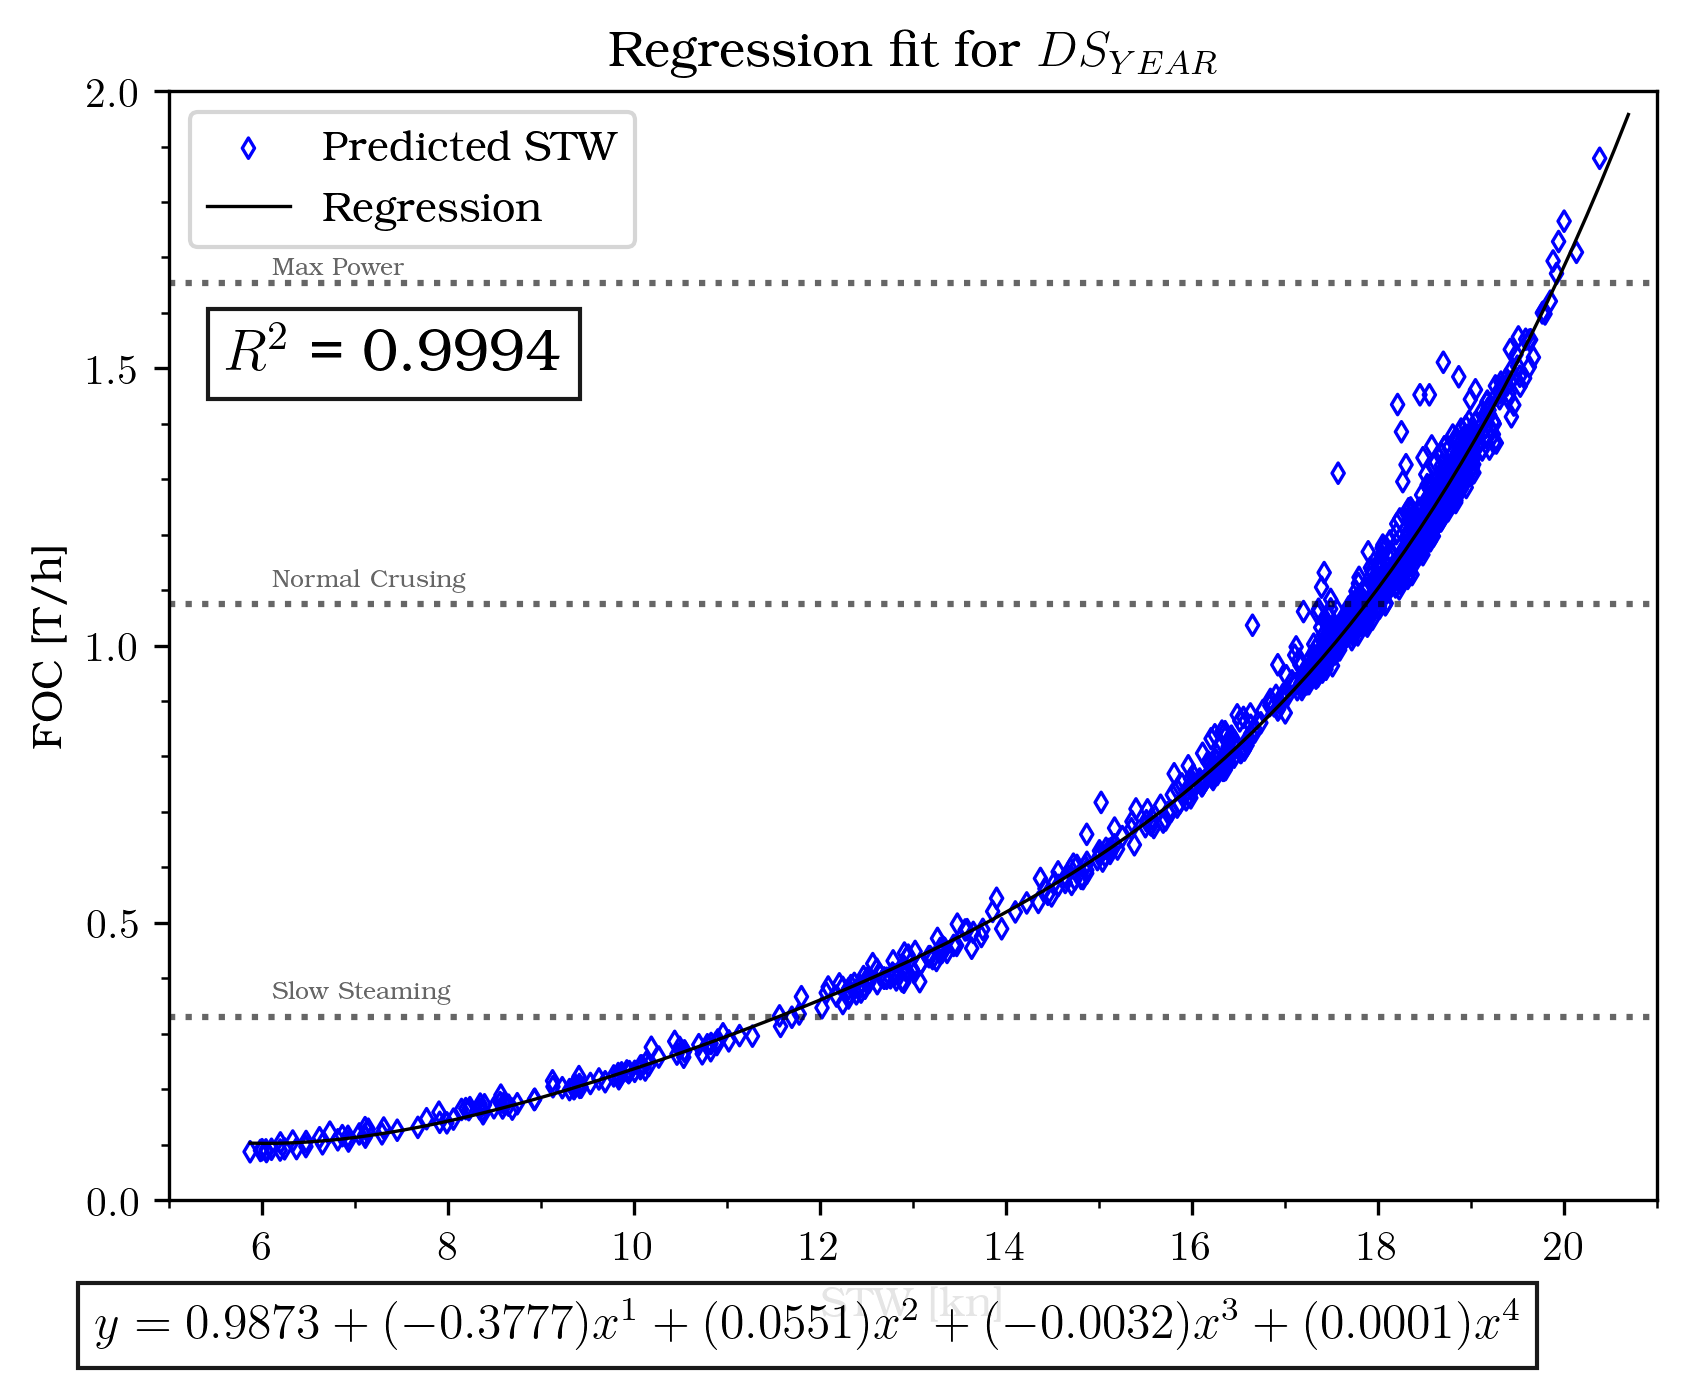

In [171]:
poly_rfr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_rf_yr,FOC_pred_rf_yr)
plt.show()

Best Polynomial Equation:
$y = 0.9873 + (-0.3777)x^1 + (0.0551)x^2 + (-0.0032)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.8990 + (-0.3479)x^1 + (0.0516)x^2 + (-0.0031)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 1.0475 + (-0.3971)x^1 + (0.0572)x^2 + (-0.0033)x^3 + (0.0001)x^4$


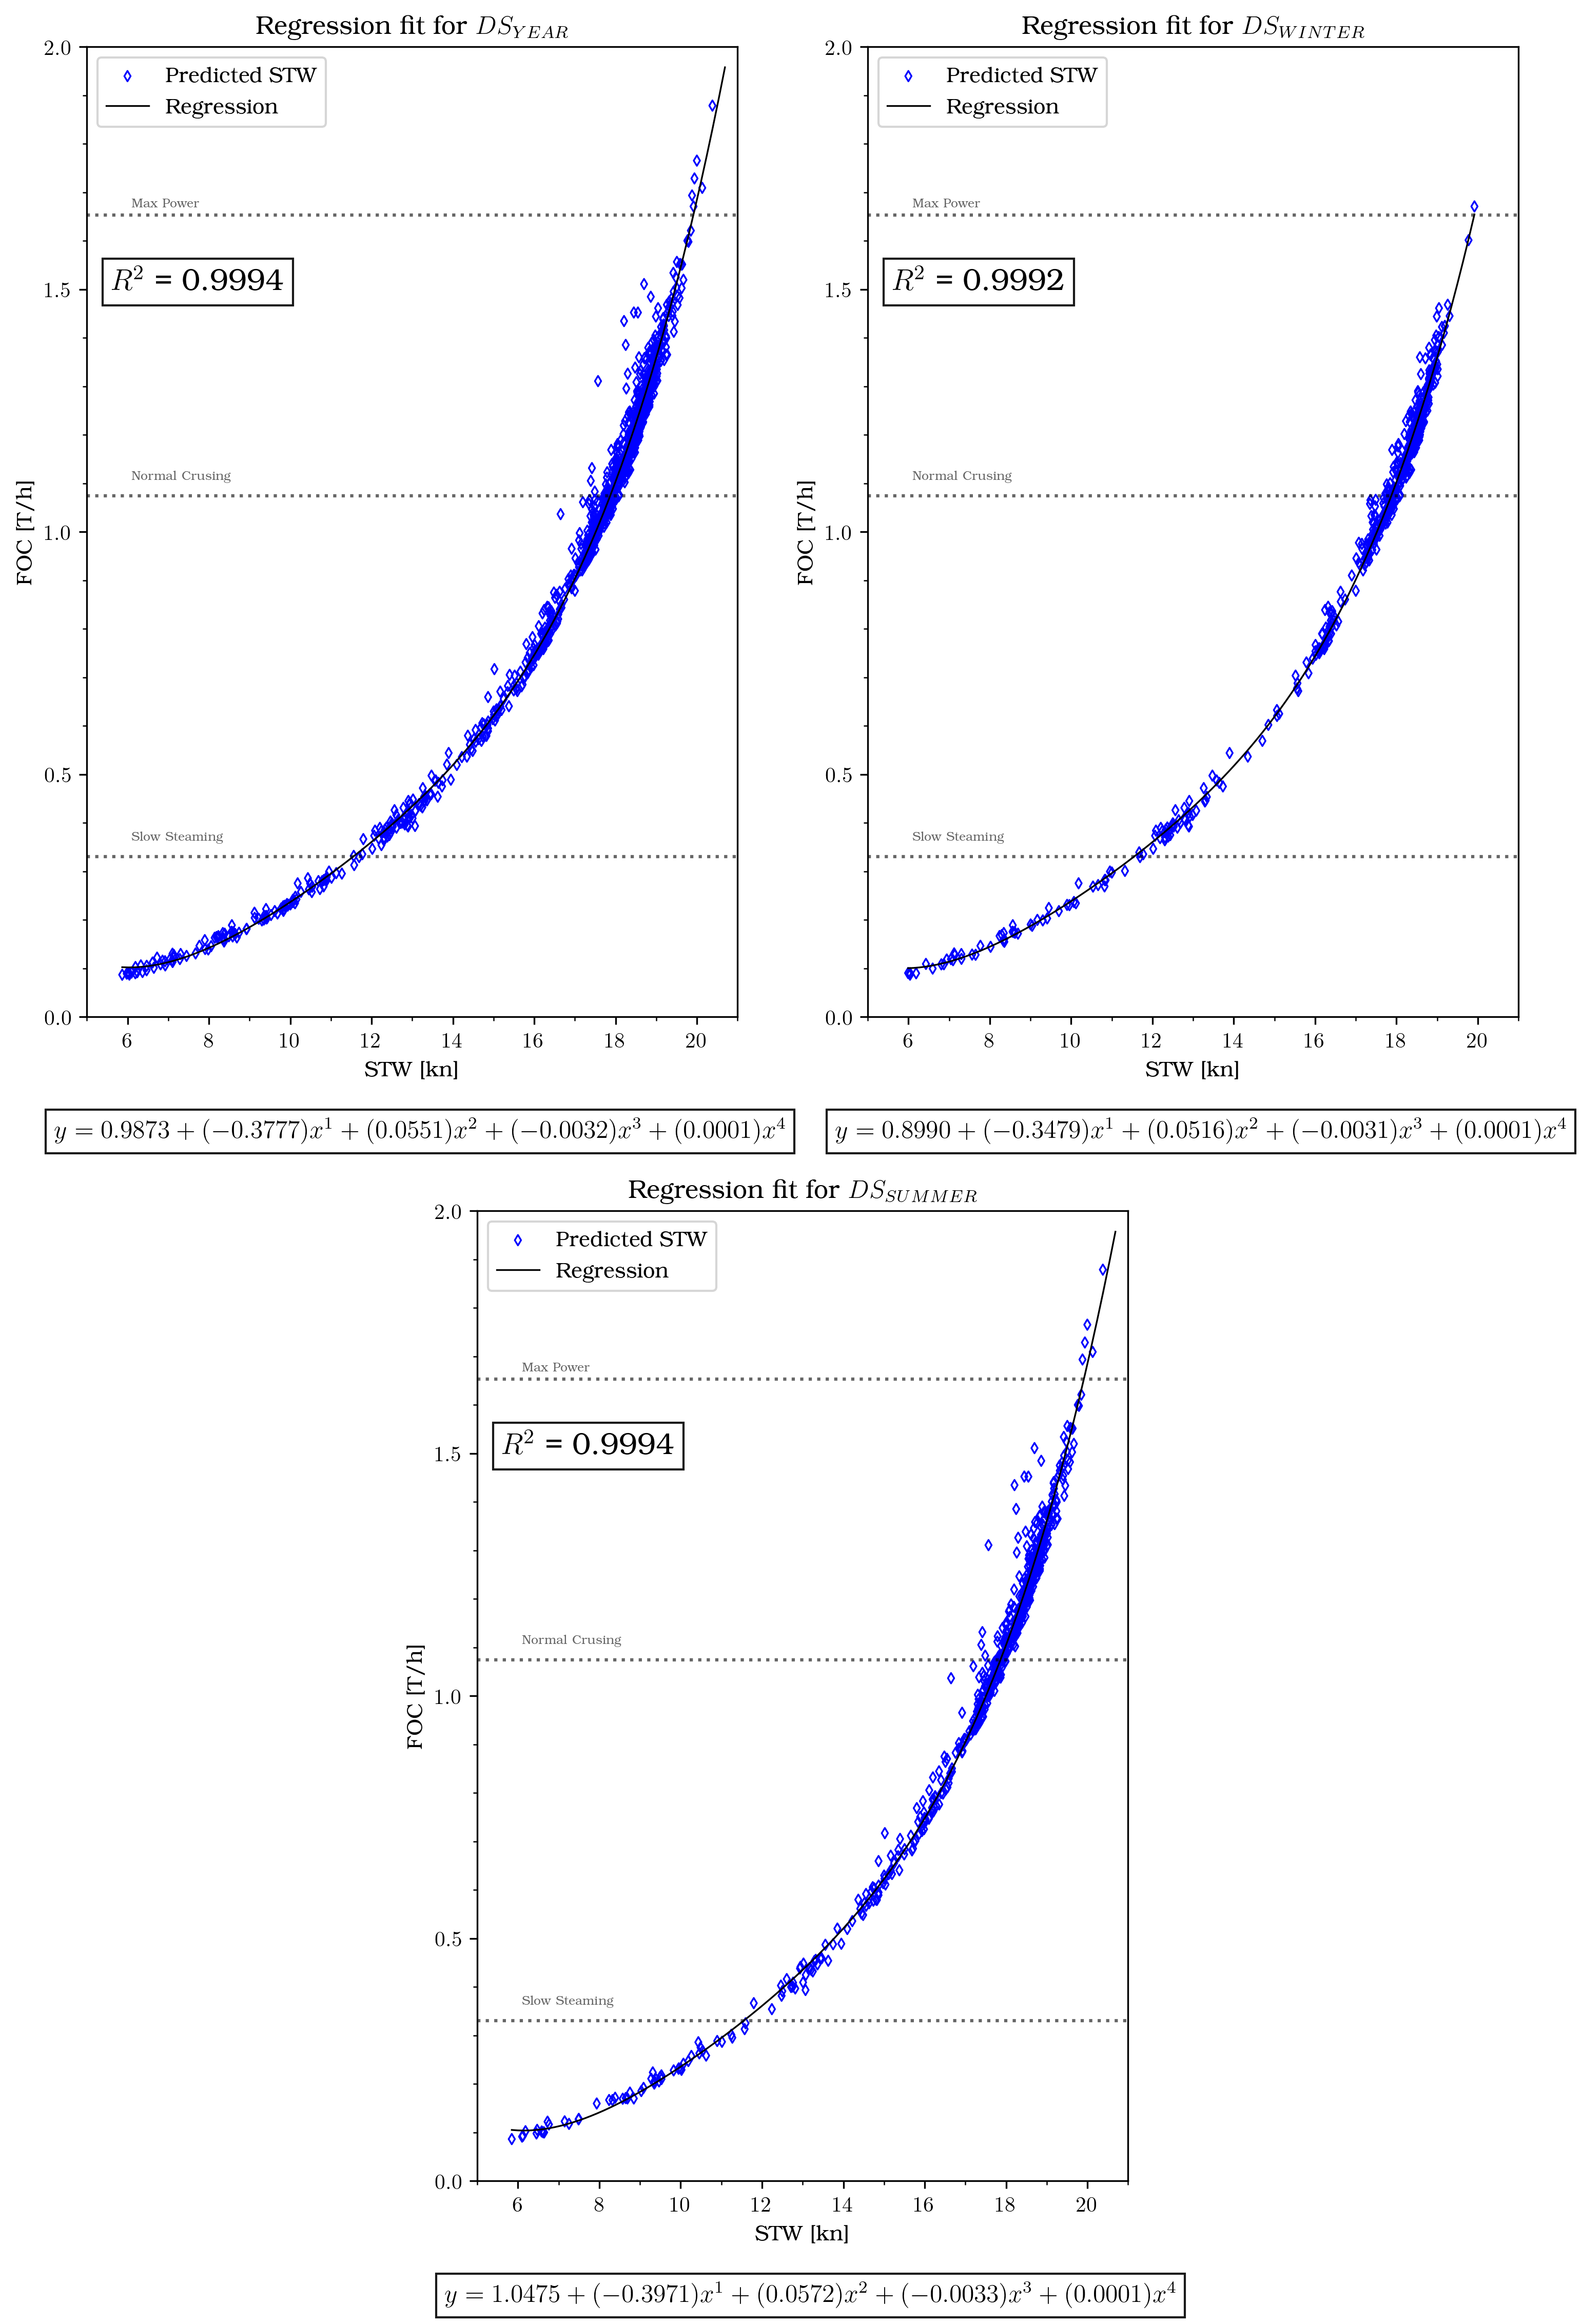

In [172]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_rfr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_rf_yr,FOC_pred_rf_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_rfr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_rf_w,FOC_pred_rf_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_rfr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_rf_s,FOC_pred_rf_s)
plt.show()

DTR

Best Polynomial Equation:
$y = 1.0779 + (-0.4121)x^1 + (0.0597)x^2 + (-0.0035)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.9388 + (-0.3638)x^1 + (0.0537)x^2 + (-0.0032)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 1.1662 + (-0.4416)x^1 + (0.0632)x^2 + (-0.0037)x^3 + (0.0001)x^4$


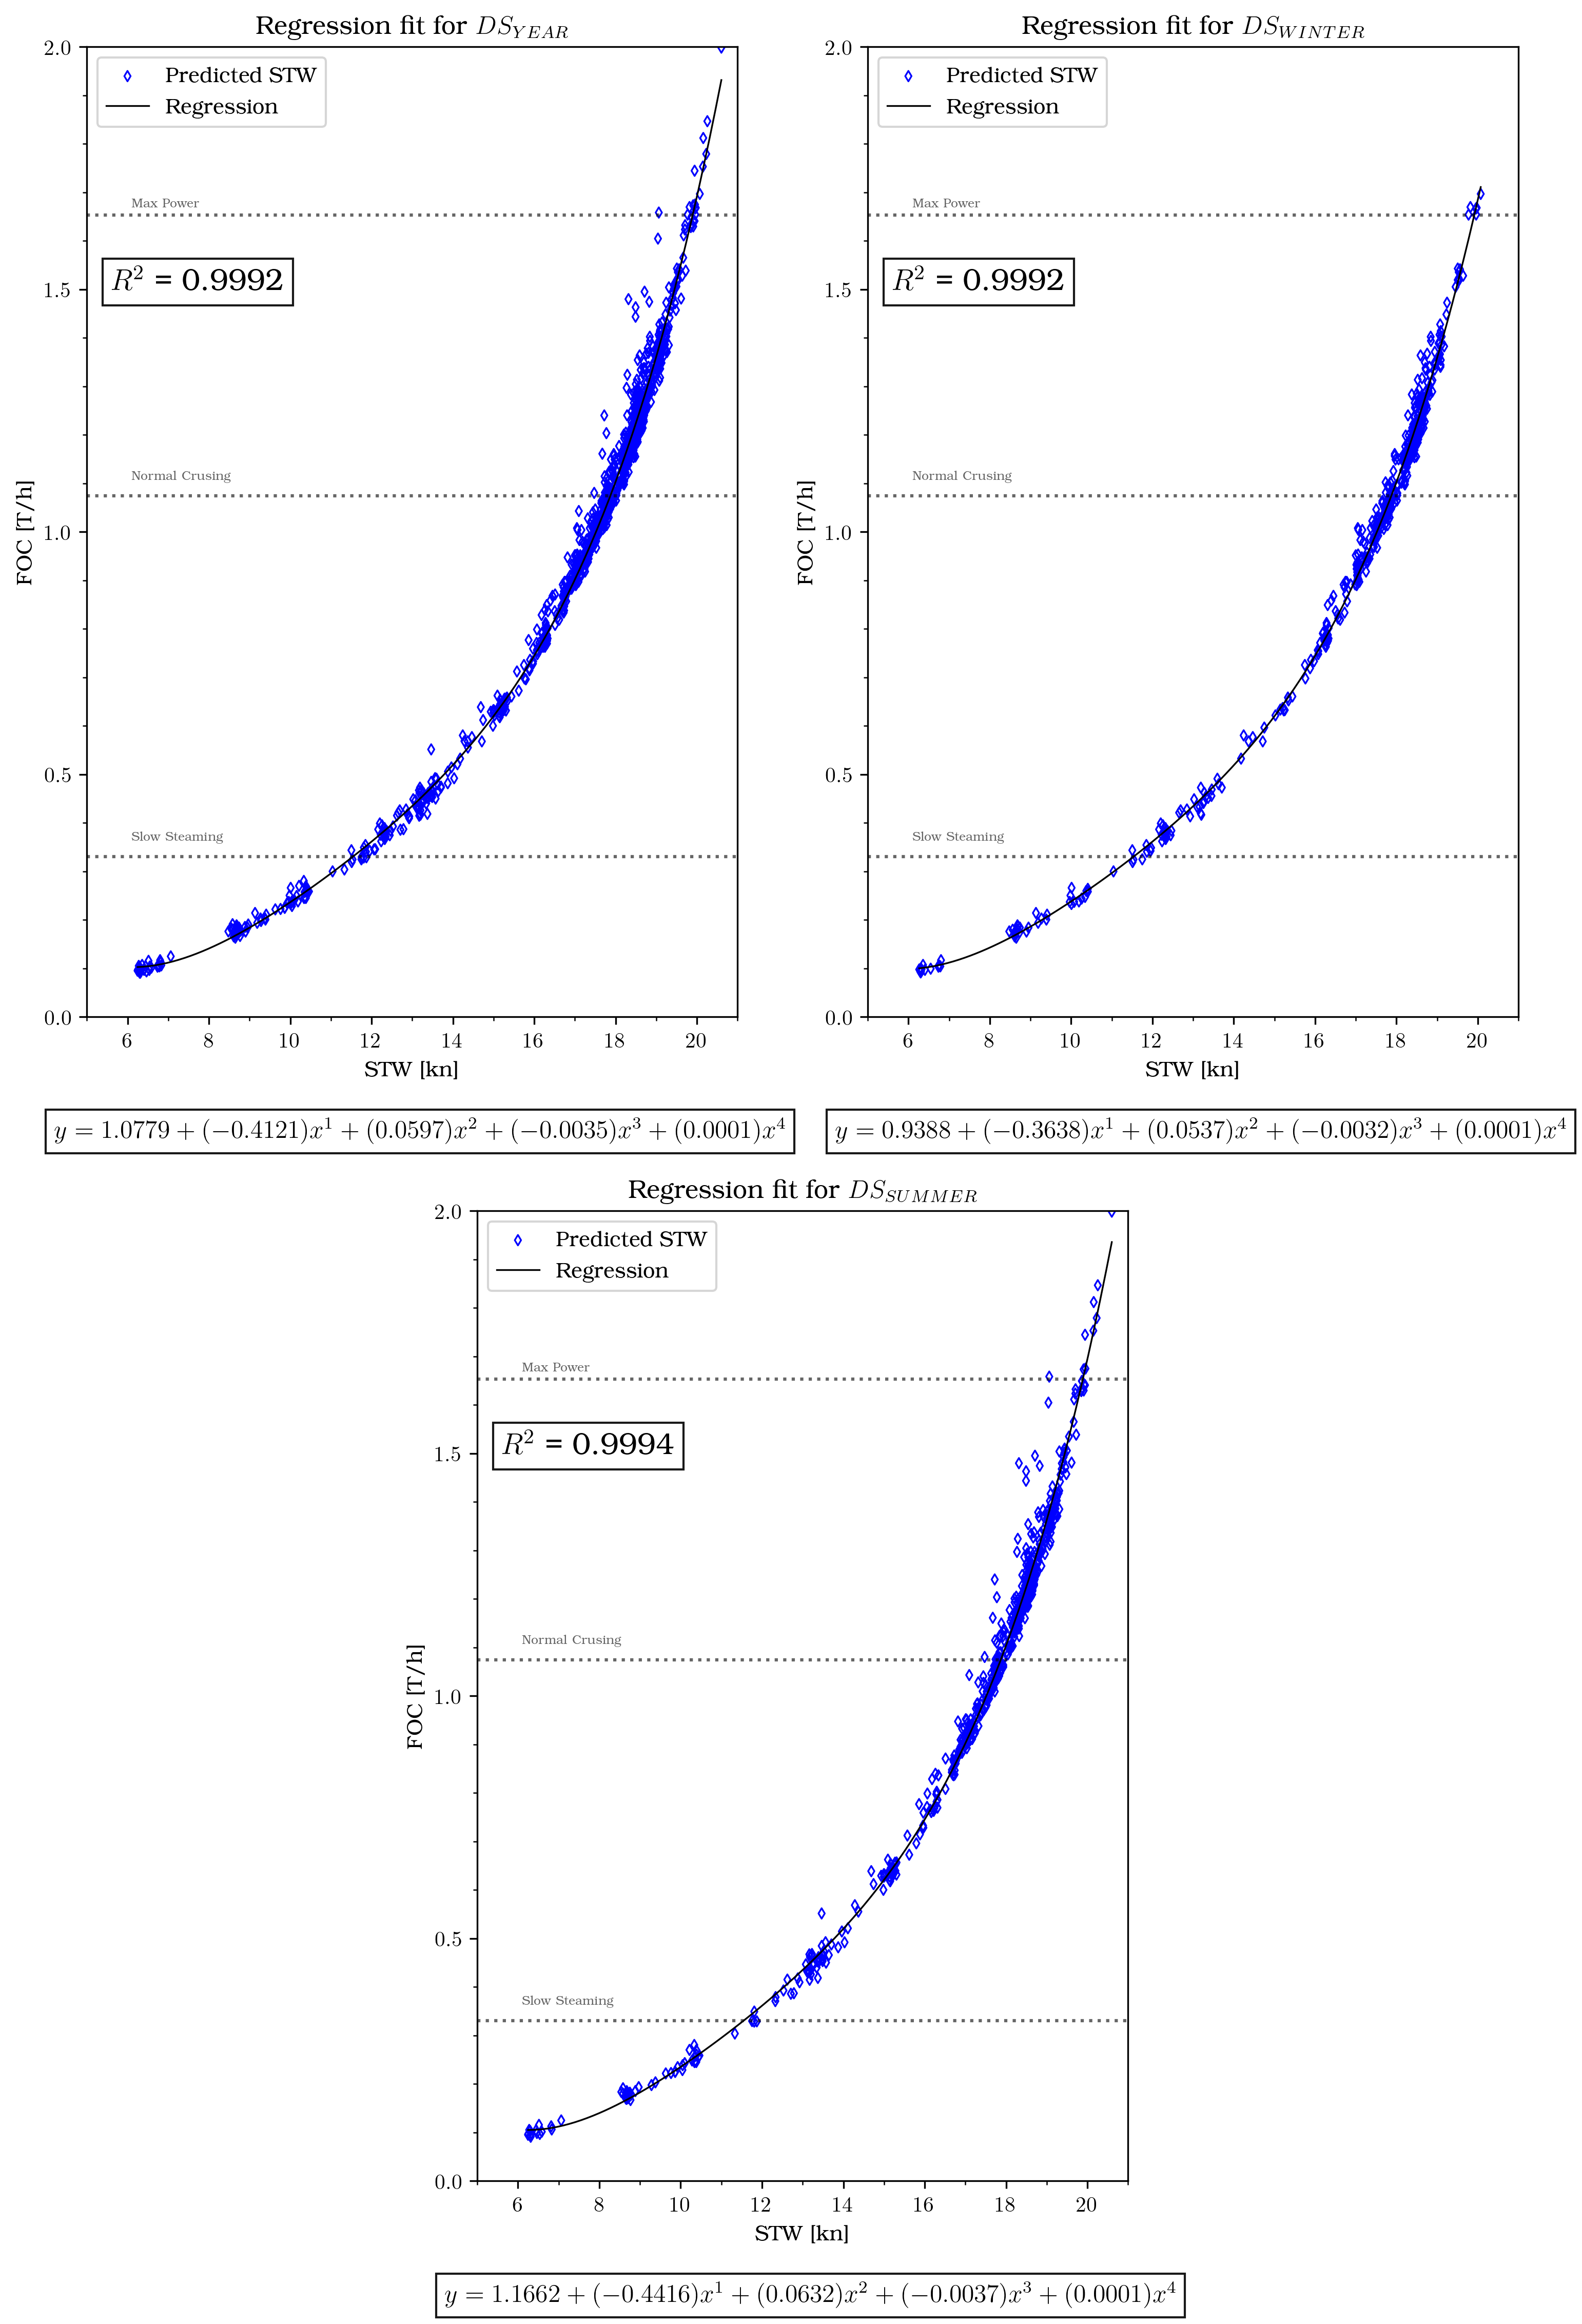

In [173]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_dtr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_dt_yr,FOC_pred_dt_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_dtr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_dt_w,FOC_pred_dt_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_dtr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_dt_s,FOC_pred_dt_s)
plt.show()

Evaluating model performance on FOC prediction

In [174]:
# This function defines the model performance for the given stw range

def evaluate_FOC(model,FOC_act,FOC_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_FOC = r2_score(FOC_act,FOC_pred)
    expVar_FOC = explained_variance_score(FOC_act,FOC_pred)
    MAE_FOC = mean_absolute_error(FOC_act,FOC_pred)
    RMSE_FOC = np.sqrt(mean_squared_error(FOC_act, FOC_pred))
    MAD_FOC = median_absolute_error(FOC_act,FOC_pred)
    MAPE_FOC = mean_absolute_percentage_error(FOC_act, FOC_pred)
    
    print(f"Model Performance of {model}")
    print(f"R^2 {Rsquared_FOC:0.4f}")
    print(f"Explained Variance {expVar_FOC:0.4f}")
    print(f"MAE {MAE_FOC:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_FOC:0.4f} T/h")
    print(f"MAD {MAD_FOC:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_FOC*100:0.4f} %")


ETR

In [175]:
# Yearly performance 


evaluate_FOC(model_etr_hpov,FOC_act_yr.dropna(),FOC_pred_yr.dropna())

Model Performance of ExtraTreesRegressor(max_depth=30, max_features=16, min_samples_split=8,
                    n_estimators=300, random_state=42)
R^2 0.7969
Explained Variance 0.8004
MAE 0.1267 T/h
RMSE FOC 0.1904 T/h
MAD 0.0822 T/h
MAPE FOC 13.9631 %


In [176]:
evaluate_FOC(model_etr_hpov,FOC_act_s.dropna(),FOC_pred_s.dropna())

Model Performance of ExtraTreesRegressor(max_depth=30, max_features=16, min_samples_split=8,
                    n_estimators=300, random_state=42)
R^2 0.7773
Explained Variance 0.7857
MAE 0.1367 T/h
RMSE FOC 0.2069 T/h
MAD 0.0882 T/h
MAPE FOC 14.3391 %


In [177]:
evaluate_FOC(model_etr_hpov,FOC_act_w.dropna(),FOC_pred_w.dropna())

Model Performance of ExtraTreesRegressor(max_depth=30, max_features=16, min_samples_split=8,
                    n_estimators=300, random_state=42)
R^2 0.8181
Explained Variance 0.8184
MAE 0.1139 T/h
RMSE FOC 0.1679 T/h
MAD 0.0731 T/h
MAPE FOC 13.2495 %


RFR

In [178]:
# On yearly data

evaluate_FOC(model_rfr_hpov,FOC_act_yr.dropna(),FOC_pred_rf_yr.dropna())

Model Performance of RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=800, random_state=42)
R^2 0.7765
Explained Variance 0.7817
MAE 0.1343 T/h
RMSE FOC 0.1997 T/h
MAD 0.0854 T/h
MAPE FOC 14.8022 %


In [179]:
evaluate_FOC(model_rfr_hpov,FOC_act_s.dropna(),FOC_pred_rf_s.dropna())

Model Performance of RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=800, random_state=42)
R^2 0.7496
Explained Variance 0.7629
MAE 0.1477 T/h
RMSE FOC 0.2194 T/h
MAD 0.0960 T/h
MAPE FOC 15.6399 %


In [180]:
evaluate_FOC(model_rfr_hpov,FOC_act_w.dropna(),FOC_pred_rf_w.dropna())

Model Performance of RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=800, random_state=42)
R^2 0.8082
Explained Variance 0.8084
MAE 0.1175 T/h
RMSE FOC 0.1725 T/h
MAD 0.0779 T/h
MAPE FOC 13.6032 %


DTR

In [181]:
evaluate_FOC(model_dtr_hpov,FOC_act_yr.dropna(),FOC_pred_dt_yr.dropna())

Model Performance of DecisionTreeRegressor(max_depth=6, max_features=11, min_samples_leaf=9,
                      min_samples_split=8)
R^2 0.6992
Explained Variance 0.7048
MAE 0.1525 T/h
RMSE FOC 0.2317 T/h
MAD 0.0973 T/h
MAPE FOC 17.4845 %


In [182]:
evaluate_FOC(model_dtr_hpov,FOC_act_s.dropna(),FOC_pred_dt_s.dropna())

Model Performance of DecisionTreeRegressor(max_depth=6, max_features=11, min_samples_leaf=9,
                      min_samples_split=8)
R^2 0.6548
Explained Variance 0.6708
MAE 0.1714 T/h
RMSE FOC 0.2576 T/h
MAD 0.1089 T/h
MAPE FOC 19.1025 %


In [183]:
evaluate_FOC(model_dtr_hpov,FOC_act_w.dropna(),FOC_pred_dt_w.dropna())

Model Performance of DecisionTreeRegressor(max_depth=6, max_features=11, min_samples_leaf=9,
                      min_samples_split=8)
R^2 0.7558
Explained Variance 0.7559
MAE 0.1288 T/h
RMSE FOC 0.1946 T/h
MAD 0.0812 T/h
MAPE FOC 15.3635 %


MLR

In [184]:
#yearly data

evaluate_FOC(model_mlr_ftr,FOC_act_yr.dropna(),FOC_pred_mlr_yr.dropna())

Model Performance of LinearRegression()
R^2 0.5684
Explained Variance 0.6078
MAE 0.1990 T/h
RMSE FOC 0.2775 T/h
MAD 0.1497 T/h
MAPE FOC 21.8852 %


In [185]:
evaluate_FOC(model_mlr_ftr,FOC_act_s.dropna(),FOC_pred_mlr_s.dropna())

Model Performance of LinearRegression()
R^2 0.5325
Explained Variance 0.5879
MAE 0.2174 T/h
RMSE FOC 0.2998 T/h
MAD 0.1553 T/h
MAPE FOC 22.6637 %


In [186]:
evaluate_FOC(model_mlr_ftr,FOC_act_w.dropna(),FOC_pred_mlr_w.dropna())

Model Performance of LinearRegression()
R^2 0.5928
Explained Variance 0.6153
MAE 0.1760 T/h
RMSE FOC 0.2513 T/h
MAD 0.1361 T/h
MAPE FOC 20.9979 %


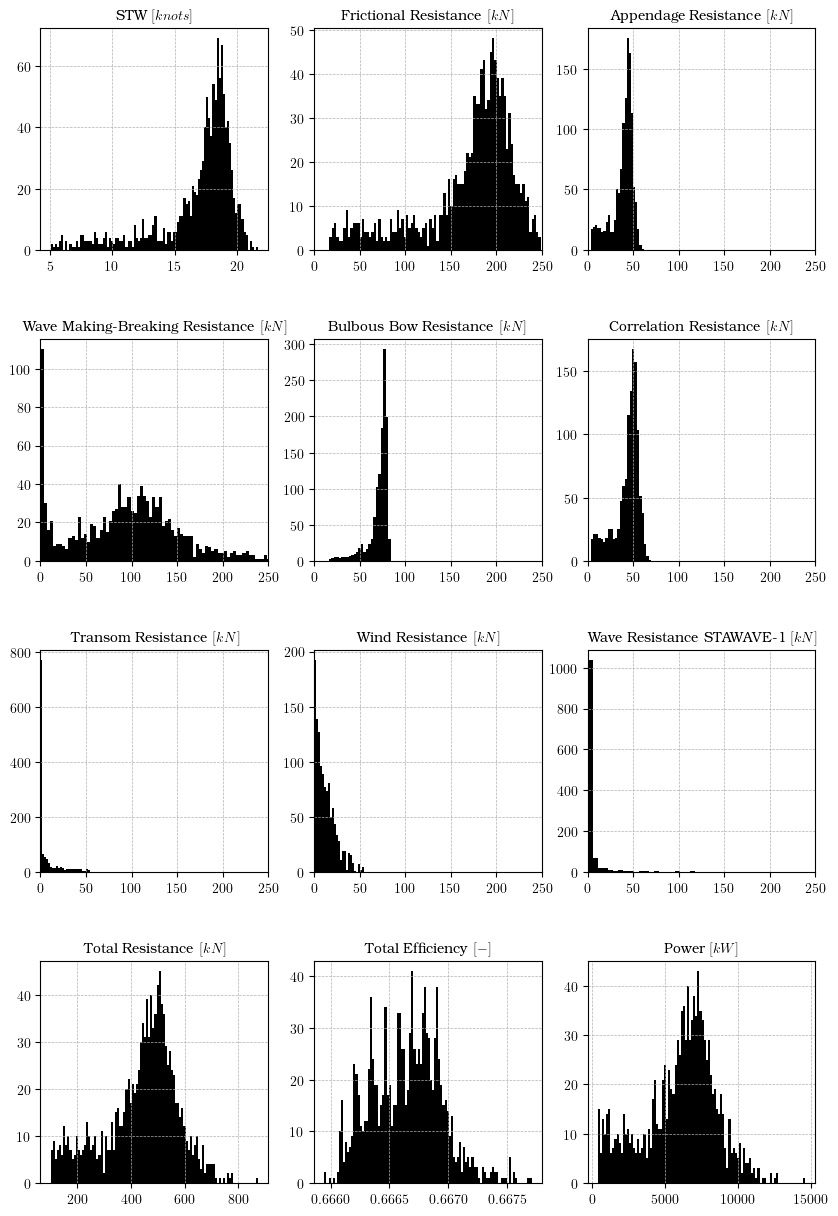

In [187]:
fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})


stw = stw_act_yr
R_f = Rf_act_yr/1e3
R_app = R_app_act_yr/1e3
R_w = R_w_act_yr/1e3
R_b = R_b_act_yr/1e3
R_tr = R_tr_act_yr/1e3
R_a = R_a_act_yr/1e3
R_aa = R_aa_act_yr/1e3
# R_aa_hm = dfprog_f['R_aa_hm']/1e3
R_awl = R_awl_act_yr/1e3
R_tot = R_tot_act_yr
# eff_h = dfprog_f['eff_h']
eff_tot = eff_tot_act_yr
P_b = P_b_act_yr
FOC = FOC_act_yr



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(stw,bins=100,color='black')
axes[0, 0].set_title(r'STW $[knots]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(R_f,bins=100,color='black')
axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 1].set_xlim(0,250)

axes[0, 2].hist(R_app,bins=25,color='black')
axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 2].set_xlim(0,250)

axes[1, 0].hist(R_w,bins=100,color='black')
axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 0].set_xlim(0,250)

axes[1, 1].hist(R_b  ,bins=25,color='black')
axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 1].set_xlim(0,250)

axes[1, 2].hist(R_a,bins=25,color='black')
axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 2].set_xlim(0,250)

axes[2, 1].hist(R_aa,bins=25,color='black')
axes[2, 1].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 1].set_xlim(0,250)

# axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(R_awl,bins=25,color='black')
axes[2, 2].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 2].set_xlim(0,250)

axes[2, 0].hist(R_tr,bins=25,color='black')
axes[2, 0].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 0].set_xlim(0,250)

axes[3, 0].hist(R_tot,bins=100,color='black')
axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(eff_h,bins=25,color='black')
# axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(eff_tot,bins=100,color='black')
axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(P_b,bins=100,color='black')
axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[4, 1].hist(FOC,bins=25,color='black')
# axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

In [188]:
def FOC_plot_yr(FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr):
    rmse_opt = [FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("FOC comparison for yearly data")
    plt.ylabel("FOC [T/h]")
    plt.xlabel("Period")
    plt.yscale('linear')
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'$FOC_{actual}$', r'$FOC_{ETR}$',
                        r'$FOC_{RFR}$', r'$FOC_{DTR}$'])

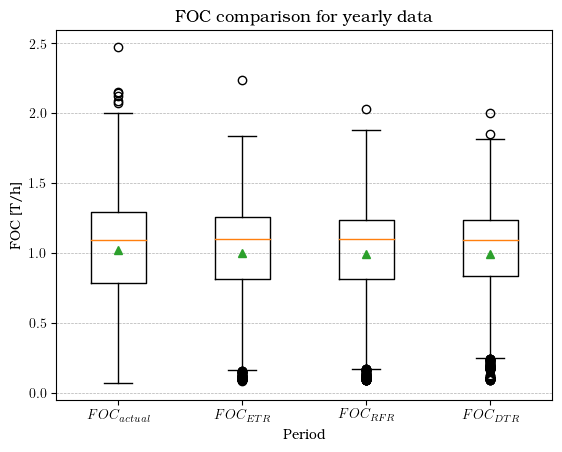

In [189]:
FOC_plot_yr(FOC_act_yr,FOC_pred_yr,FOC_pred_rf_yr,FOC_pred_dt_yr)
plt.show()